# __<font size="5"> Goal </font>__ 

To predict the rate per night of Airbnb in Austin, TX (YEAR 2019).

# __<font size="5"> Background </font>__

Airbnb, Inc. is an online marketplace for arranging or offering lodging, primarily homestays, or tourism experiences. The company does not own any of the real estate, nor does it host events; it acts as a broker, receiving commissions from each booking. The company is based in San Francisco, California, United States.

The project here looks at the various aspects of Airbnb and see what combination of features will most accurately predict the rate per night of a given listing. Here, I have fosused only on the data collected for the city of `Austin, Texas` in Year 2019 ( till Novenber).  __In addition__ to this, this notebook also  shows the `crimes reported` within the areas as included by the Airbnb dataset.

__Finally__, a map is generated using the boundaries and zipcodes for better visulaization.


`WHENEVER` we plan our trip, we always look for few major features - reviews, location, property type, parking, breakfast included, cancellation policy and few other. The analysis in this notebook is done including most of these features. 

__<font color="green" size = "5" > DataSets </font>__

__<font size = '3'> a. Airbnb, Austin, Texas </font>__

The dataset is downloaded from the http://insideairbnb.com/get-the-data.html for the city of Austin, Texas. The dataset used in this study is the `“listings.csv.gz”` for Austin , Texas, as compiled on 2019, November. 

__<font size = '3'> b. Crime Data, Austin, Texas </font>__

The crime dataset was retrieved from official data portal https://data.austintexas.gov/Public-Safety/Crime-Reports-2018/vmn9-3bvu

__<font size = '3'> c. Zip Codes GeoJSON, Austin, Texas </font>__

The boundary coordinates of every zip code within the city was obtained from https://data.austintexas.gov/Locations-and-Maps/Zipcodes/ghsj-v65t. 

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import re # The Python module provides full support for Perl-like regular expressions in Python
import json #(JavaScript Object Notation)
import requests #The requests library is the standard for making HTTP requests in Python. *for API
import warnings #Warnings are issued to alert the user of certain conditions which aren't exactly exceptions. 
import numpy as np 
import pandas as pd
import geopandas as gpd #GeoPandas is an open source project to make working with geospatial data in python easier
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from collections import defaultdict #This module implements specialized container datatypes providing 
#alternatives to Python’s general purpose built-in containers, dict, list, set, and tuple
#dict subclass that calls a factory function to supply missing values
from collections import OrderedDict # dict subclass that remembers the order entries were added
from IPython.display import HTML
from shapely.geometry import Point #this will be helpful while building the map using boundaries data

In [3]:
from sklearn.exceptions import DataConversionWarning

warnings.simplefilter(action="ignore", \
                      category=FutureWarning)

warnings.filterwarnings(action='ignore', \
                        category=DataConversionWarning)

In [4]:
# Importing Data 

# Data is downloaded from the database provided above and saved as `listings` as give by airbnb as well
listings = pd.read_csv("/Users/nitinmahajan/Desktop/Austin_2019_AirBNB/listings-4.csv", dtype={"zipcode":str})

/Users/nitinmahajan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


__Note__- How to deal with `Zipcode data`? Please reads related article to dive deep

The `zipcode` column can be manually assigned a string `datatype` because in the United States zip codes  are written in a dashed format, 5 digits format or with State Initials followed by 5 or 9 digits code. The zipcode (latitude and longitude can be exoplored though) feature will serve as the basis for the location of the listings. So, zipcode is the primary column to start the `data cleaning` and `data wrangling`. 

---

__<font color  = 'green' size="5"> Exploratory Data Analysis (EDA) </font>__

In [5]:
listings.shape

(11250, 106)

The dataset in its original form has `106 columns` and a total of `11250 rows`.

Considering 106 columns, preview of the dataframe will be printed in truncated form while usiing the function like `describe` and `head` to avoid this followiing code (FOR LOOP) will help to read the dataframe in appropriate manner. 

In [6]:
# Information (df.info)
for i in range(0, len(listings.columns), 10):
    columns = listings.columns[i:i+10]
    display(listings[columns].head())

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview
0,2265,https://www.airbnb.com/rooms/2265,20191112224534,2019-11-13,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,This colorful and clean 1923 house was complet...,Zen East is situated in a vibrant & diverse mu...,none,NaN
1,5245,https://www.airbnb.com/rooms/5245,20191112224534,2019-11-13,"Eco friendly, Colorful, Clean, Cozy monthly share",Situated in a vibrant & diverse multicultural ...,"This green, colorful, clean and cozy house was...",Situated in a vibrant & diverse multicultural ...,none,NaN
2,5456,https://www.airbnb.com/rooms/5456,20191112224534,2019-11-13,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,Cute Private Studio apartment located in Willo...,Great central location for walking to Convent...,none,My neighborhood is ideally located if you want...
3,5769,https://www.airbnb.com/rooms/5769,20191112224534,2019-11-13,NW Austin Room,NaN,Looking for a comfortable inexpensive room to ...,Looking for a comfortable inexpensive room to ...,none,Quiet neighborhood with lots of trees and good...
4,6413,https://www.airbnb.com/rooms/6413,20191112224534,2019-11-13,Gem of a Studio near Downtown,"Great studio apartment, perfect for couples or...","(License #114332) Large, contemporary studio a...","Great studio apartment, perfect for couples or...",none,Travis Heights is one of the oldest neighborho...


,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id
0,A 2013 Genuine Buddy Scooter 125 may be availa...,5 min walk to Capitol Metro Rail (train that t...,"Several local restaurants, small clubs, music ...","Depending on your dates and arrival time, I am...",• Check-in time is 4 pm. Check out is 11 am. I...,NaN,NaN,https://a0.muscache.com/im/pictures/4740524/63...,NaN,2466
1,Please note: A two story studio was built in t...,NaN,NaN,"I should be available, upon your arrival, to a...",A brief profile for all guests along with phot...,NaN,NaN,https://a0.muscache.com/im/pictures/5167505/b3...,NaN,2466
2,Parking on street requires a permit. Permits ...,"Bus stop around the block. Uber, Lyft, Ride, ...",Guests have access to patio.,I am happy to welcome my guests and show them in.,No Pets allowed. No smoking in the room. No m...,NaN,NaN,https://a0.muscache.com/im/pictures/14084884/b...,NaN,8028
3,NaN,We are approximately 16 miles from downtown Au...,Gravel Parking Kitchen,We interact with our guests as little or as mu...,I will need to see identification at check in....,NaN,NaN,https://a0.muscache.com/im/pictures/23822033/a...,NaN,8186
4,Our calendar only extends a few months. If you...,"Parking for our place is on the street, roughl...",Private patio with lounge chairs and umbrella.,"You may see us during your stay, but you'll ma...",Posted prices include the 9% in local occupanc...,NaN,NaN,https://a0.muscache.com/im/pictures/349818/97e...,NaN,13879


,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url
0,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a few hours,100%,NaN,t,https://a0.muscache.com/im/users/2466/profile_...
1,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a few hours,100%,NaN,t,https://a0.muscache.com/im/users/2466/profile_...
2,https://www.airbnb.com/users/show/8028,Sylvia,2009-02-16,"Austin, Texas, United States",I am a licensed Real Estate Broker and owner o...,within a few hours,100%,NaN,t,https://a0.muscache.com/im/users/8028/profile_...
3,https://www.airbnb.com/users/show/8186,Elizabeth,2009-02-19,"Austin, Texas, United States",We're easygoing professionals that enjoy meeti...,within an hour,100%,NaN,t,https://a0.muscache.com/im/users/8186/profile_...
4,https://www.airbnb.com/users/show/13879,Todd,2009-04-17,"Austin, Texas, United States","We're a young family that likes to travel, we ...",within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/user/4f35e...


,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed
0,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Austin, TX, United States",East Downtown,78702
1,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Austin, TX, United States",East Downtown,78702
2,https://a0.muscache.com/im/users/8028/profile_...,East Downtown,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Austin, TX, United States",East Downtown,78702
3,https://a0.muscache.com/im/users/8186/profile_...,SW Williamson Co.,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Austin, TX, United States",SW Williamson Co.,78729
4,https://a0.muscache.com/im/pictures/user/4f35e...,Travis Heights,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"Austin, TX, United States",Travis Heights,78704


,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude
0,NaN,Austin,TX,78702,Austin,"Austin, TX",US,United States,30.27750,-97.71398
1,NaN,Austin,TX,78702,Austin,"Austin, TX",US,United States,30.27577,-97.71379
2,NaN,Austin,TX,78702,Austin,"Austin, TX",US,United States,30.26112,-97.73448
3,NaN,Austin,TX,78729,Austin,"Austin, TX",US,United States,30.45596,-97.78370
4,NaN,Austin,TX,78704,Austin,"Austin, TX",US,United States,30.24829,-97.73726


,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet
0,f,House,Entire home/apt,4,2.0,2.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN
1,t,House,Private room,2,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN
2,t,Guesthouse,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Pets live...",NaN
3,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN
4,t,Guesthouse,Entire home/apt,2,1.0,NaN,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",550.0


,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights
0,$225.00,NaN,NaN,$500.00,$100.00,4,$30.00,30,90,30
1,$100.00,NaN,NaN,$500.00,$75.00,2,$35.00,30,60,30
2,$95.00,NaN,NaN,$100.00,NaN,2,$45.00,2,90,2
3,$40.00,$160.00,NaN,NaN,NaN,2,$0.00,1,14,1
4,$99.00,$700.00,"$1,900.00",NaN,$50.00,2,$25.00,3,365,3


,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90
0,30,90,90,30.0,90.0,3 months ago,t,0,0,0
1,30,60,60,30.0,60.0,5 months ago,t,0,0,0
2,2,90,90,2.0,90.0,6 days ago,t,10,24,54
3,1,14,14,1.0,14.0,2 days ago,t,0,3,13
4,3,365,365,3.0,365.0,5 days ago,t,14,14,14


,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin
0,0,2019-11-13,24,1,2009-03-17,2019-03-16,93.0,9.0,10.0,10.0
1,0,2019-11-13,9,0,2009-03-19,2018-03-14,91.0,10.0,8.0,10.0
2,304,2019-11-13,508,47,2009-03-08,2019-10-28,96.0,10.0,10.0,10.0
3,13,2019-11-13,257,19,2010-04-10,2019-11-03,98.0,10.0,10.0,10.0
4,14,2019-11-13,104,23,2009-12-14,2019-11-05,99.0,10.0,10.0,10.0


,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture
0,10.0,8.0,9.0,f,NaN,"{""Texas State""}",f,f,strict_14_with_grace_period,f
1,9.0,10.0,9.0,f,NaN,"{""Texas State""}",f,f,strict_14_with_grace_period,f
2,10.0,10.0,10.0,f,NaN,"{""Texas State""}",f,f,strict_14_with_grace_period,f
3,10.0,10.0,10.0,f,NaN,"{""Texas State""}",f,f,moderate,t
4,10.0,10.0,10.0,f,32041657928,"{""Texas State""}",t,f,strict_14_with_grace_period,f


,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,f,3,2,1,0,0.18
1,f,3,2,1,0,0.07
2,t,1,1,0,0,3.90
3,t,1,0,1,0,2.20
4,f,1,1,0,0,0.86


<Figure size 1080x432 with 0 Axes>

Text(0.5, 1.0, 'Missing Values (HeatMap) - YEAR 2019')

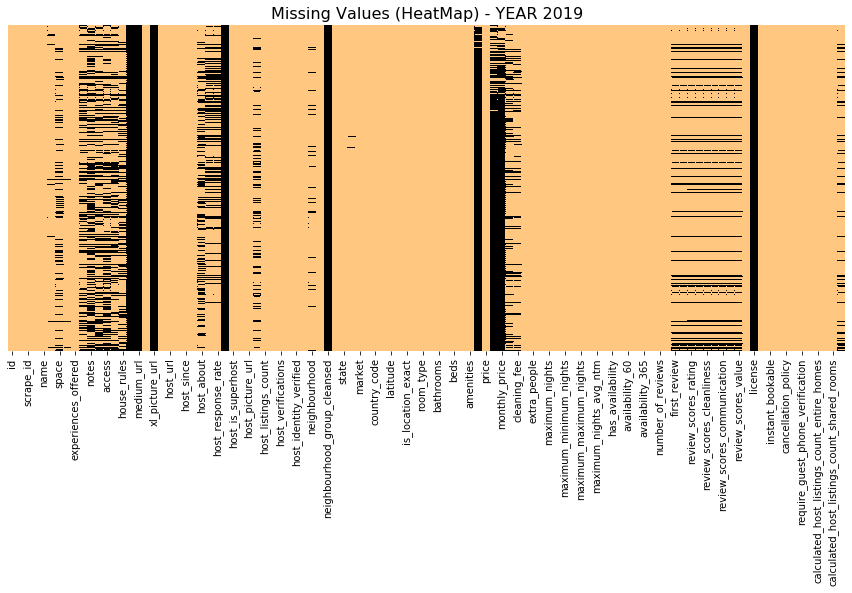

In [7]:
# Visualization of missing values as heatmap
import matplotlib.style as style #sets the size of the charts
plt.figure(figsize=(15,6))
plt.title('Missing Values (HeatMap) - YEAR 2019', fontsize = 16)
sns.heatmap(listings.isnull(),cbar=False,yticklabels=False,cmap = 'copper_r') #Check 'cmap'
plt.show()

In [8]:
listings_info = {
    "Series":
    listings.columns,
    "Total_count": [listings[column].count() for column in listings.columns],
    "NaN_count":
    [listings[column].isna().sum() for column in listings.columns],
    "Percent of NaN (%)":
    [(listings[column].isna().sum() / len(listings)) * 100
     for column in listings.columns],
    "dtypes": [listings[column].dtypes for column in listings.columns]
}

listings_info = pd.DataFrame(listings_info).set_index("Series")
for i in range(0, len(listings_info), 10):
    display(listings_info.iloc[i:i + 10])

,Total_count,NaN_count,Percent of NaN (%),dtypes
Series,,,,
id,11250,0,0.000000,int64
listing_url,11250,0,0.000000,object
scrape_id,11250,0,0.000000,int64
last_scraped,11250,0,0.000000,object
name,11250,0,0.000000,object
summary,10844,406,3.608889,object
space,8603,2647,23.528889,object
description,11070,180,1.600000,object
experiences_offered,11250,0,0.000000,object


,Total_count,NaN_count,Percent of NaN (%),dtypes
Series,,,,
notes,5279,5971,53.075556,object
transit,7017,4233,37.626667,object
access,6696,4554,40.480000,object
interaction,7481,3769,33.502222,object
house_rules,7625,3625,32.222222,object
thumbnail_url,0,11250,100.000000,float64
medium_url,0,11250,100.000000,float64
picture_url,11250,0,0.000000,object
xl_picture_url,0,11250,100.000000,float64


,Total_count,NaN_count,Percent of NaN (%),dtypes
Series,,,,
host_url,11250,0,0.000000,object
host_name,11247,3,0.026667,object
host_since,11247,3,0.026667,object
host_location,11218,32,0.284444,object
host_about,7318,3932,34.951111,object
host_response_time,7939,3311,29.431111,object
host_response_rate,7939,3311,29.431111,object
host_acceptance_rate,0,11250,100.000000,float64
host_is_superhost,11247,3,0.026667,object


,Total_count,NaN_count,Percent of NaN (%),dtypes
Series,,,,
host_picture_url,11247,3,0.026667,object
host_neighbourhood,8675,2575,22.888889,object
host_listings_count,11247,3,0.026667,float64
host_total_listings_count,11247,3,0.026667,float64
host_verifications,11250,0,0.000000,object
host_has_profile_pic,11247,3,0.026667,object
host_identity_verified,11247,3,0.026667,object
street,11250,0,0.000000,object
neighbourhood,10373,877,7.795556,object


,Total_count,NaN_count,Percent of NaN (%),dtypes
Series,,,,
neighbourhood_group_cleansed,0,11250,100.000000,float64
city,11248,2,0.017778,object
state,11246,4,0.035556,object
zipcode,11157,93,0.826667,object
market,11235,15,0.133333,object
smart_location,11250,0,0.000000,object
country_code,11250,0,0.000000,object
country,11250,0,0.000000,object
latitude,11250,0,0.000000,float64


,Total_count,NaN_count,Percent of NaN (%),dtypes
Series,,,,
is_location_exact,11250,0,0.000000,object
property_type,11250,0,0.000000,object
room_type,11250,0,0.000000,object
accommodates,11250,0,0.000000,int64
bathrooms,11235,15,0.133333,float64
bedrooms,11245,5,0.044444,float64
beds,11238,12,0.106667,float64
bed_type,11250,0,0.000000,object
amenities,11250,0,0.000000,object


,Total_count,NaN_count,Percent of NaN (%),dtypes
Series,,,,
price,11250,0,0.000000,object
weekly_price,932,10318,91.715556,object
monthly_price,777,10473,93.093333,object
security_deposit,8153,3097,27.528889,object
cleaning_fee,9154,2096,18.631111,object
guests_included,11250,0,0.000000,int64
extra_people,11250,0,0.000000,object
minimum_nights,11250,0,0.000000,int64
maximum_nights,11250,0,0.000000,int64


,Total_count,NaN_count,Percent of NaN (%),dtypes
Series,,,,
maximum_minimum_nights,11250,0,0.0,int64
minimum_maximum_nights,11250,0,0.0,int64
maximum_maximum_nights,11250,0,0.0,int64
minimum_nights_avg_ntm,11250,0,0.0,float64
maximum_nights_avg_ntm,11250,0,0.0,float64
calendar_updated,11250,0,0.0,object
has_availability,11250,0,0.0,object
availability_30,11250,0,0.0,int64
availability_60,11250,0,0.0,int64


,Total_count,NaN_count,Percent of NaN (%),dtypes
Series,,,,
availability_365,11250,0,0.000000,int64
calendar_last_scraped,11250,0,0.000000,object
number_of_reviews,11250,0,0.000000,int64
number_of_reviews_ltm,11250,0,0.000000,int64
first_review,9037,2213,19.671111,object
last_review,9037,2213,19.671111,object
review_scores_rating,8927,2323,20.648889,float64
review_scores_accuracy,8922,2328,20.693333,float64
review_scores_cleanliness,8922,2328,20.693333,float64


,Total_count,NaN_count,Percent of NaN (%),dtypes
Series,,,,
review_scores_communication,8921,2329,20.702222,float64
review_scores_location,8916,2334,20.746667,float64
review_scores_value,8917,2333,20.737778,float64
requires_license,11250,0,0.000000,object
license,33,11217,99.706667,object
jurisdiction_names,11250,0,0.000000,object
instant_bookable,11250,0,0.000000,object
is_business_travel_ready,11250,0,0.000000,object
cancellation_policy,11250,0,0.000000,object


,Total_count,NaN_count,Percent of NaN (%),dtypes
Series,,,,
require_guest_phone_verification,11250,0,0.000000,object
calculated_host_listings_count,11250,0,0.000000,int64
calculated_host_listings_count_entire_homes,11250,0,0.000000,int64
calculated_host_listings_count_private_rooms,11250,0,0.000000,int64
calculated_host_listings_count_shared_rooms,11250,0,0.000000,int64
reviews_per_month,9037,2213,19.671111,float64


<Figure size 1080x1080 with 0 Axes>

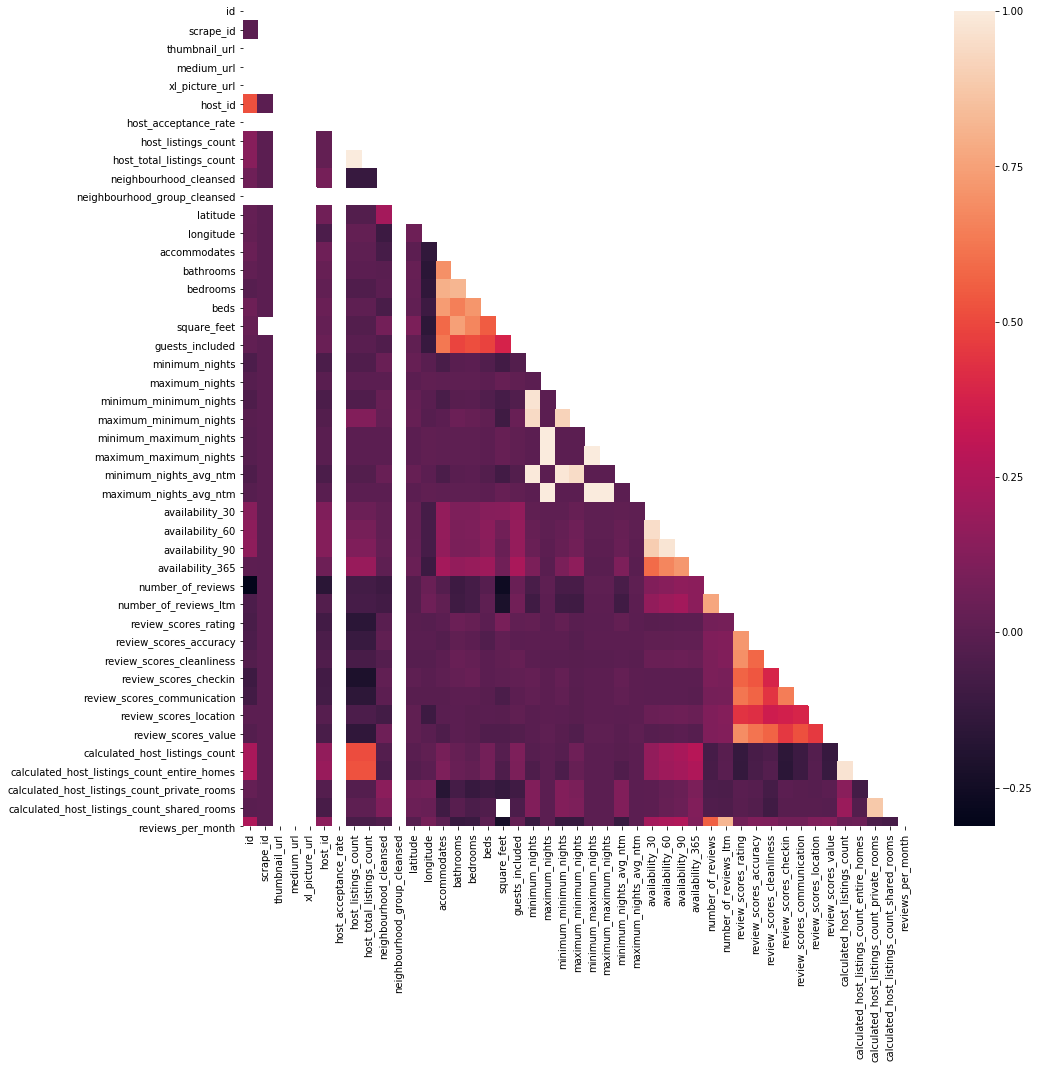

In [9]:
plt.figure(figsize=(15,15))
corr = listings.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
heatmap = sns.heatmap(corr, mask=mask,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
heatmap
plt.show()

In [10]:
listings_objects = listings.select_dtypes(include=['object'])
listings_objects.columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'picture_url',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'is_location_exact',
       'property_type', 'room_type', 'bed_type', 'amenities', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'extra_people', 'calendar_updated', 'has_availability',
       'calendar_last_scraped', 'first_review', 'last_review',
       'requires_license', 'license', 'jurisdiction_names', 'inst

In [11]:
listings_numerics = listings.select_dtypes(exclude=['object'])
listings_numerics.columns

Index(['id', 'scrape_id', 'thumbnail_url', 'medium_url', 'xl_picture_url',
       'host_id', 'host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'guests_included',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count',
       'calculated_host_listings_count_en

In [12]:
#rows which dont have any zip
no_zip = listings[listings.zipcode.isna()].index
no_zip = no_zip.tolist()

print("Total number of missing 'zipcodes': ", len(no_zip))

print(no_zip)

Total number of missing 'zipcodes':  93
[72, 938, 941, 1028, 1041, 1112, 1355, 1378, 1487, 1608, 1612, 1794, 1802, 2177, 2185, 2354, 2356, 2362, 2400, 2434, 2477, 2490, 2562, 2568, 2635, 2789, 3046, 3129, 3146, 3170, 3253, 3261, 3299, 3575, 3667, 3858, 3940, 3954, 4115, 4222, 4233, 4237, 4332, 4527, 4905, 4909, 4910, 4915, 4916, 4920, 4930, 4932, 4933, 4942, 4946, 4947, 4949, 4952, 5234, 5581, 5770, 5830, 5850, 5896, 5954, 5999, 6175, 6183, 6281, 6385, 6493, 6667, 6725, 6760, 6762, 6840, 7093, 7242, 7345, 7392, 7473, 7477, 7497, 7506, 7510, 7518, 7519, 7537, 7551, 7594, 7706, 7857, 9949]


As, there are only 93 values are missing in the zip, we can either remove these rows from the dataset or we can use longitude and latitude to get the exact location

__Note__ `Reverse geocoding` is the process of taking a latitude and longitude pair and providing the associated address, or nearest address point. MAP QUEST API can be another option, to get the zipcodes from the latitude and logitude information. 

In [13]:
# make a list of indexes which we have to drop from the `listing` datframe

no_zipcodes = [
    72, 938, 941, 1028, 1041, 1112, 1355, 1378, 1487, 1608, 1612, 1794, 1802,
    2177, 2185, 2354, 2356, 2362, 2400, 2434, 2477, 2490, 2562, 2568, 2635,
    2789, 3046, 3129, 3146, 3170, 3253, 3261, 3299, 3575, 3667, 3858, 3940,
    3954, 4115, 4222, 4233, 4237, 4332, 4527, 4905, 4909, 4910, 4915, 4916,
    4920, 4930, 4932, 4933, 4942, 4946, 4947, 4949, 4952, 5234, 5581, 5770,
    5830, 5850, 5896, 5954, 5999, 6175, 6183, 6281, 6385, 6493, 6667, 6725,
    6760, 6762, 6840, 7093, 7242, 7345, 7392, 7473, 7477, 7497, 7506, 7510,
    7518, 7519, 7537, 7551, 7594, 7706, 7857, 9949
]

In [14]:
# Drop the rows with missing zipcode

listings = listings.drop(listings.index[[
    72, 938, 941, 1028, 1041, 1112, 1355, 1378, 1487, 1608, 1612, 1794, 1802,
    2177, 2185, 2354, 2356, 2362, 2400, 2434, 2477, 2490, 2562, 2568, 2635,
    2789, 3046, 3129, 3146, 3170, 3253, 3261, 3299, 3575, 3667, 3858, 3940,
    3954, 4115, 4222, 4233, 4237, 4332, 4527, 4905, 4909, 4910, 4915, 4916,
    4920, 4930, 4932, 4933, 4942, 4946, 4947, 4949, 4952, 5234, 5581, 5770,
    5830, 5850, 5896, 5954, 5999, 6175, 6183, 6281, 6385, 6493, 6667, 6725,
    6760, 6762, 6840, 7093, 7242, 7345, 7392, 7473, 7477, 7497, 7506, 7510,
    7518, 7519, 7537, 7551, 7594, 7706, 7857, 9949
]])

In [15]:
listings.shape

(11157, 106)

In [16]:
listings.zipcode.value_counts()

78704       2167
78702       1458
78741        762
78701        675
78705        607
78703        572
78745        527
78751        476
78723        350
78746        302
78721        232
78758        212
78734        209
78722        203
78757        200
78744        180
78748        154
78756        152
78731        132
78752        123
78759        117
78749        112
78754        101
78737         99
78724         91
78727         90
78729         90
78753         86
78725         72
78733         72
78728         67
78735         65
78717         52
78736         52
78738         49
78730         48
78750         48
78747         47
78732         43
78739         22
78726         12
78742          7
78660          5
78652          4
78669          2
78719          2
78620          2
78613          1
78619          1
78712          1
TX 78702       1
78767          1
78653          1
78681          1
Name: zipcode, dtype: int64

Value_counts points out that there is one row with different zipcode style i.e TX 78702

In [17]:
# remove that as well 

listings.drop(listings.loc[listings['zipcode']=='TX 78702'].index, inplace=True)


In [18]:
#check one more time 

no_zip = listings[listings.zipcode.isna()].index
no_zip = no_zip.tolist()

print("Total number of missing 'zipcodes: " , len(no_zip))
print(no_zip)

Total number of missing 'zipcodes:  0
[]


---

__What we see while booking a trip on AirBnb?__

Answer is (1) Location and (2) Reviews about `HOST` and (3) Property Type 

There are three major columns in the listings dataframe that would gve an idea about the `HOST` : host_is_superhost, host_verifications_count, host_identity_verified columns.

As Per Airbnb: `Superhosts` are experienced hosts and have known to provide extraordinary experiences for their guests. 


<font size =5 > Feature __`Host_Type`__ </font>

In [19]:
listings.host_is_superhost.value_counts()

f    7151
t    4002
Name: host_is_superhost, dtype: int64

[Text(0, 0.5, 'Number of hosts'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Distribution of Host Status - Austin, TX-2019')]

[Text(0, 0, 'Superhost'), Text(0, 0, 'Regular_Host')]

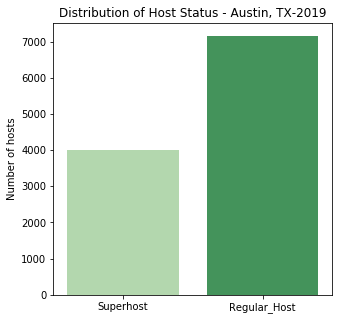

The number of Superhosts:  4002
The number of regular hosts:  7151


In [20]:
host_status = listings["host_is_superhost"]

f, axes = plt.subplots(figsize=(5,5))
ax = sns.countplot(x=host_status, palette="Greens")
ax.set(title="Distribution of Host Status - Austin, TX-2019", \
       xlabel="", ylabel="Number of hosts")
ax.set_xticklabels(["Superhost", "Regular_Host"])
plt.show()

print("The number of Superhosts: ", len(listings[host_status == "t"]))
print("The number of regular hosts: ", len(listings[host_status == "f"]))

There are three missing values in the `host_is_superhost` coulumns. So we can fill that with the `regulat host` after converting these to boolean. 

In [21]:
superhost = listings["host_is_superhost"]
superhost = superhost.apply(lambda row: 1 if row=="t" else 0) #convert to boolean
listings["host_is_superhost"] = superhost

print("The number of NaNs after conversion:", 
      len(listings[listings["host_is_superhost"].isna()]))

The number of NaNs after conversion: 0


<font size =5 > Feature __`Property Type`__ </font>

The dataset has multiple columns describing the nature of the properties : the property_type, room_type, and cancellation_policy. 

`Note` : There are no NaN entries for these.

In [22]:
print("Unique 'property_type' values:\n",
      listings["property_type"].unique())
print("Unique 'room_type' values:\n", 
      listings["room_type"].unique())
print("Unique 'cancellation_policy' values:\n",
      listings["cancellation_policy"].unique())

Unique 'property_type' values:
 ['House' 'Guesthouse' 'Condominium' 'Guest suite' 'Apartment' 'Townhouse'
 'Bungalow' 'Loft' 'Other' 'Cabin' 'Bed and breakfast' 'Campsite' 'Tent'
 'Villa' 'Camper/RV' 'Cottage' 'Tiny house' 'Farm stay'
 'Serviced apartment' 'Boutique hotel' 'Dome house' 'Bus' 'Tipi'
 'Treehouse' 'Barn' 'Boat' 'Hostel' 'Aparthotel' 'Yurt' 'Chalet'
 'Houseboat' 'Resort' 'Hotel' 'Earth house']
Unique 'room_type' values:
 ['Entire home/apt' 'Private room' 'Hotel room' 'Shared room']
Unique 'cancellation_policy' values:
 ['strict_14_with_grace_period' 'moderate' 'flexible' 'super_strict_30'
 'super_strict_60' 'luxury_moderate']


[Text(0, 0.5, 'number of listings'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Distribution of Property Type')]

[Text(0, 0, 'House'),
 Text(0, 0, 'Guesthouse'),
 Text(0, 0, 'Condominium'),
 Text(0, 0, 'Guest suite'),
 Text(0, 0, 'Apartment'),
 Text(0, 0, 'Townhouse'),
 Text(0, 0, 'Bungalow'),
 Text(0, 0, 'Loft'),
 Text(0, 0, 'Other'),
 Text(0, 0, 'Cabin'),
 Text(0, 0, 'Bed and breakfast'),
 Text(0, 0, 'Campsite'),
 Text(0, 0, 'Tent'),
 Text(0, 0, 'Villa'),
 Text(0, 0, 'Camper/RV'),
 Text(0, 0, 'Cottage'),
 Text(0, 0, 'Tiny house'),
 Text(0, 0, 'Farm stay'),
 Text(0, 0, 'Serviced apartment'),
 Text(0, 0, 'Boutique hotel'),
 Text(0, 0, 'Dome house'),
 Text(0, 0, 'Bus'),
 Text(0, 0, 'Tipi'),
 Text(0, 0, 'Treehouse'),
 Text(0, 0, 'Barn'),
 Text(0, 0, 'Boat'),
 Text(0, 0, 'Hostel'),
 Text(0, 0, 'Aparthotel'),
 Text(0, 0, 'Yurt'),
 Text(0, 0, 'Chalet'),
 Text(0, 0, 'Houseboat'),
 Text(0, 0, 'Resort'),
 Text(0, 0, 'Hotel'),
 Text(0, 0, 'Earth house')]

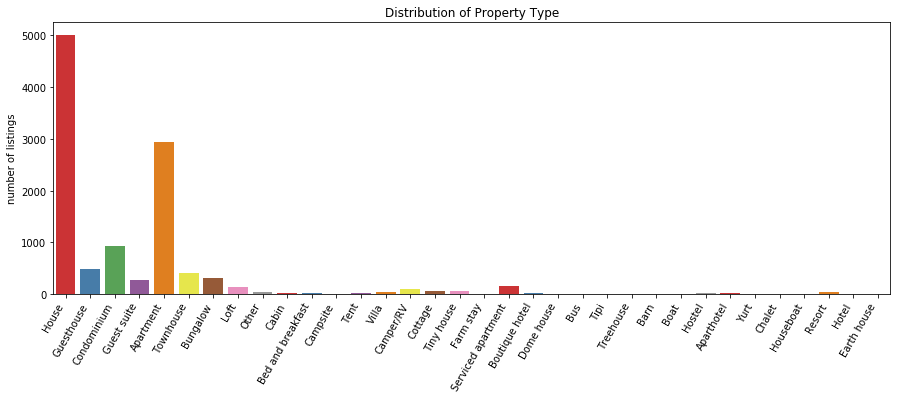

In [23]:
property_type = listings["property_type"]

f, axes = plt.subplots(figsize=(15,5))
ax = sns.countplot(x=property_type, palette="Set1")
ax.set(title="Distribution of Property Type", 
       xlabel="", ylabel="number of listings")
ax.set_xticklabels(labels=property_type.unique(), 
                   rotation=60, ha="right")
plt.show()

In [24]:
listings["property_type"].value_counts()

House                 5003
Apartment             2932
Condominium            939
Guesthouse             494
Townhouse              414
Bungalow               309
Guest suite            266
Serviced apartment     153
Loft                   136
Camper/RV               91
Cottage                 66
Tiny house              62
Other                   42
Resort                  41
Villa                   40
Hostel                  27
Cabin                   27
Bed and breakfast       18
Boutique hotel          15
Tent                    14
Aparthotel              13
Farm stay               10
Campsite                 8
Boat                     7
Yurt                     6
Tipi                     4
Treehouse                4
Hotel                    4
Barn                     3
Houseboat                2
Dome house               2
Bus                      2
Chalet                   1
Earth house              1
Name: property_type, dtype: int64

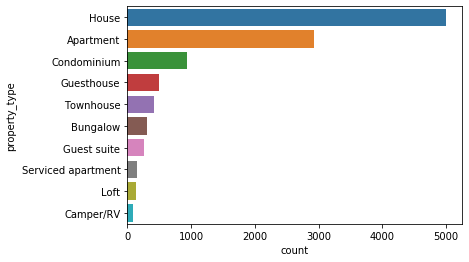

In [25]:
sns.countplot(y = listings["property_type"], order = listings['property_type'].value_counts().iloc[:10].index)
plt.show()

Top three types included : House, Apartment and Condominium, I used simplify condition below to keep only the these three top entries while the rest are converted to 'Others'. 

In [26]:
simplify = lambda row: "Other" if (row != "House") \
            and (row != "Apartment") and (row != "Condominium") else row

listings["property_type (simple)"] = property_type.apply(simplify)

display(listings[["property_type", "property_type (simple)"]].head(10))

,property_type,property_type (simple)
0,House,House
1,House,House
2,Guesthouse,Other
3,House,House
4,Guesthouse,Other
5,Guesthouse,Other
6,House,House
7,House,House
8,House,House
9,Condominium,Condominium


<font size =5 > Feature __`Host_Verification`__ </font>

__VERIFICATIONS__

The host_verifications enlists the verification methods performed by the host to prove their online identity. Key is : "The more verifications a host undergoes, the more the host will appear trustworthy".

In [27]:
listings["host_verifications"].dtype

dtype('O')

In [28]:
listings["host_verifications"].head(3)

0    ['email', 'phone', 'facebook', 'reviews', 'kba']
1    ['email', 'phone', 'facebook', 'reviews', 'kba']
2                ['email', 'phone', 'reviews', 'kba']
Name: host_verifications, dtype: object

In [29]:
listings["host_verifications"].value_counts().head()

['email', 'phone', 'reviews', 'kba']                       1053
['email', 'phone']                                          838
['email', 'phone', 'reviews']                               630
['email', 'phone', 'reviews', 'jumio', 'government_id']     623
['email', 'phone', 'facebook', 'reviews', 'kba']            431
Name: host_verifications, dtype: int64

In this way, we can get the count but the combinations will be many. For expample, Host-varification can be `THREE` with either _['email', 'phone', 'reviews']_  or _['email', 'phone', 'work_email']_. To avoid this and to count how many have 3 0r 4 0r more irrespective of the mode of verification, we would use teh `eval` function.   

In [30]:
verifications = listings["host_verifications"]

verifications = verifications.apply(lambda row: eval(row) \
                                    if row != "None" else [])
verifications = verifications.apply(lambda row: len(row))

listings["host_verifications_count"] = verifications

display(listings[["host_verifications_count", \
                  "host_verifications"]].head(20))


### To better understand, compare the rows with `host_verifications_count = 5` (rows 0, 1, 5, 9, 13, 15,17, 19)###

,host_verifications_count,host_verifications
0,5,"['email', 'phone', 'facebook', 'reviews', 'kba']"
1,5,"['email', 'phone', 'facebook', 'reviews', 'kba']"
2,4,"['email', 'phone', 'reviews', 'kba']"
3,6,"['email', 'phone', 'reviews', 'jumio', 'govern..."
4,8,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
5,5,"['email', 'phone', 'facebook', 'reviews', 'kba']"
6,7,"['email', 'phone', 'facebook', 'reviews', 'jum..."
7,10,"['email', 'phone', 'facebook', 'reviews', 'jum..."
8,4,"['email', 'phone', 'reviews', 'kba']"
9,5,"['email', 'phone', 'facebook', 'reviews', 'kba']"


In [31]:
counts = listings["host_verifications_count"]
print(counts.value_counts())

5     1932
6     1847
4     1628
7     1322
3     1172
8     1013
2      927
9      847
10     216
1      169
11      51
12      27
0        4
13       1
Name: host_verifications_count, dtype: int64


[Text(0, 0.5, 'number of hosts'),
 Text(0.5, 0, 'Number of verifications modes'),
 Text(0.5, 1.0, 'Distribution of the Number of Host Verifications')]

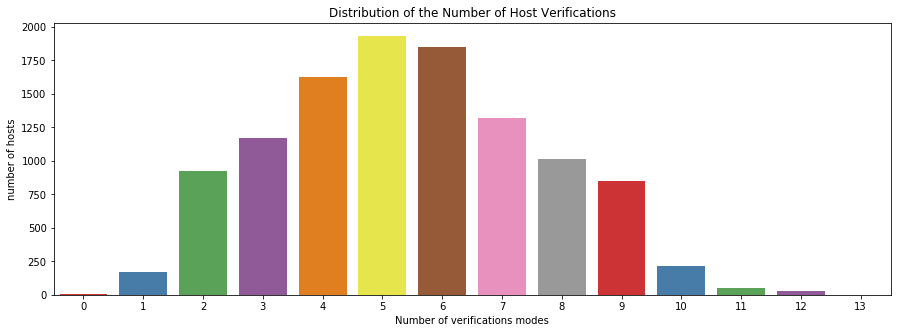

In [32]:
f, axes = plt.subplots(figsize=(15,5))
ax = sns.countplot(x=counts, palette="Set1")
ax.set(title="Distribution of the Number of Host Verifications",
       xlabel="Number of verifications modes", ylabel="number of hosts")
plt.show()

[Text(0, 0.5, 'number of hosts'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Distribution of Verified Hosts')]

[Text(0, 0, 'verified'), Text(0, 0, 'unverified')]

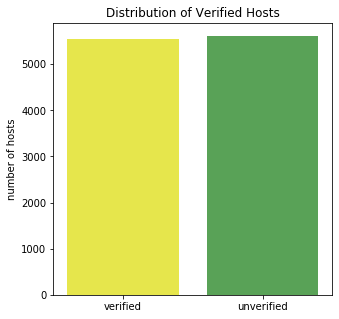

In [33]:
verified = listings["host_identity_verified"]

f, axes = plt.subplots(figsize=(5,5))
ax = sns.countplot(x=verified, palette="Set1_r")
ax.set(title="Distribution of Verified Hosts", \
       xlabel="", ylabel="number of hosts")
ax.set_xticklabels(["verified", "unverified"])
plt.show()

In [34]:
verified = verified.apply(lambda row: \
                          1 if row=="t" else 0)
listings["host_identity_verified"] = verified

<font size =5 > Feature __`EDA for few other important features`__ </font> 

Room Type, Cancellation Policies and type of beds

[[<matplotlib.axis.YTick at 0x1a247d0d30>,
 (0, 11156),
 Text(0, 0.5, ''),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Distribution of Room Type')]

[Text(0, 0, 'Entire home/apt'),
 Text(0, 0, 'Private room'),
 Text(0, 0, 'Hotel room'),
 Text(0, 0, 'Shared room')]

[[<matplotlib.axis.YTick at 0x1a244a3e10>,
 (0, 11156),
 Text(0, 0.5, ''),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Distribution of Cancellation Policy Type')]

[Text(0, 0, 'strict_14_with_grace_period'),
 Text(0, 0, 'moderate'),
 Text(0, 0, 'flexible'),
 Text(0, 0, 'super_strict_30'),
 Text(0, 0, 'super_strict_60'),
 Text(0, 0, 'luxury_moderate')]

[[<matplotlib.axis.YTick at 0x1a24dcc048>,
 (0, 11156),
 Text(0, 0.5, ''),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Distribution of Bed Type')]

[Text(0, 0, 'Real Bed'),
 Text(0, 0, 'Futon'),
 Text(0, 0, 'Couch'),
 Text(0, 0, 'Airbed'),
 Text(0, 0, 'Pull-out Sofa')]

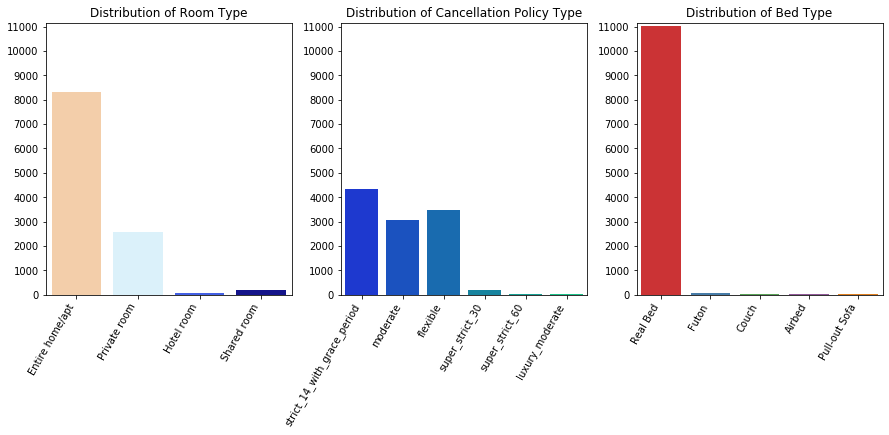

In [35]:
count = len(listings)
ticks = [idx for idx in range(0, count, 1000)]

room_type = listings["room_type"]
cancellation = listings["cancellation_policy"]
bed_type = listings["bed_type"]

f, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = sns.countplot(x=listings["room_type"], palette="flag", ax=axes[0])
ax.set(title="Distribution of Room Type",
       xlabel="", ylabel="", \
       ylim=[0,count], yticks=ticks)
ax.set_xticklabels(labels=listings["room_type"].unique(), rotation=60, ha="right")

ax = sns.countplot(x=listings["cancellation_policy"], palette="winter", ax=axes[1])
ax.set(title="Distribution of Cancellation Policy Type",
       xlabel="",
       ylabel="",
       ylim=[0, count],
       yticks=ticks)
ax.set_xticklabels(labels=listings["cancellation_policy"].unique(), rotation=60, ha="right")

ax = sns.countplot(x=listings["bed_type"], palette="Set1", ax=axes[2])
ax.set(title="Distribution of Bed Type",
       xlabel="",
       ylabel="",
       ylim=[0, count],
       yticks=ticks)
ax.set_xticklabels(labels=listings["bed_type"].unique(), rotation=60, ha="right")

plt.show()

<font size =5 > Feature __`Amenities`__ </font>

`Note`: This coulmn in the dataset is also bit complicated to analyse.


The amenities include parking, family-friendly, self check, TV, WiFi, pets allowed or not etc. 

In [36]:
amenities = listings["amenities"]

private_entrance = amenities.apply(lambda row: 1 
                                   if "Private entrance" in row 
                                   else 0)

pets_allowed = amenities.apply(lambda row: 1 
                               if ("Cat(s)" in row)
                               or ("Dog(s)" in row) 
                               or ("Pet(s)" in row) 
                               or ("Pets allowed" in row) 
                               else 0)
self_checkin = amenities.apply(lambda row: 1 
                               if "Self check-in" in row else 0)


listings["Private Entry"] = private_entrance
listings["Pets OK"] = pets_allowed
listings["Self Check-in"] = self_checkin


display(listings[["Private Entry", "Pets OK", 
                  "Self Check-in"]].head())

,Private Entry,Pets OK,Self Check-in
0,1,1,1
1,0,1,0
2,1,1,0
3,0,1,0
4,0,1,0


[[<matplotlib.axis.YTick at 0x1a2453ddd8>,
 (0, 10000)]

[[<matplotlib.axis.YTick at 0x1a24f33e48>,
 (0, 10000)]

[[<matplotlib.axis.YTick at 0x1a24ebdf60>,
 (0, 10000)]

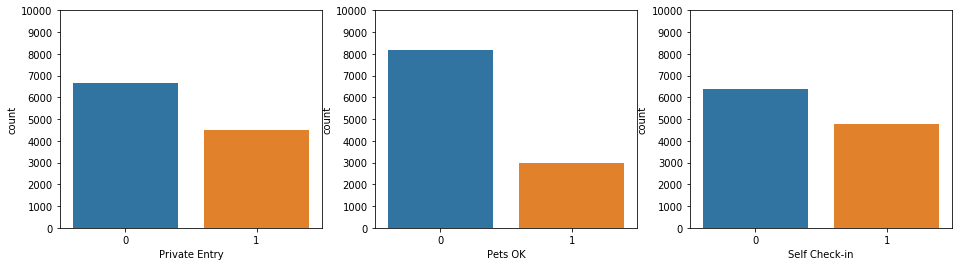

In [37]:
count = len(listings)

f, axes = plt.subplots(1, 3, figsize=(16,4))

ax = sns.countplot(x=listings["Private Entry"], 
                   ax=axes[0])
ax.set(ylim=[0,10000], yticks=ticks)

ax = sns.countplot(x=listings["Pets OK"],
                   ax=axes[1])
ax.set(ylim=[0,10000], yticks=ticks)

ax = sns.countplot(x=listings["Self Check-in"], 
                   ax=axes[2])
ax.set(ylim=[0,10000], yticks=ticks)

plt.show()

For analysis and for model, five more features have been explored from the dataset, which included accommodates, guests_included, extra_people, minimum_nights, number_of_reviews. The box plot and distplot was genrtaed to know the distribution of these variables in the data set.

In [38]:
listings["extra_people"].dtype

dtype('O')

In [39]:
listings["extra_people"].head()

0    $30.00
1    $35.00
2    $45.00
3     $0.00
4    $25.00
Name: extra_people, dtype: object

In [40]:
extra_people = listings["extra_people"].str.replace("$", "")
extra_people = extra_people.astype(float)
listings["extra_people"] = extra_people.fillna(0)

<Figure size 720x1800 with 0 Axes>

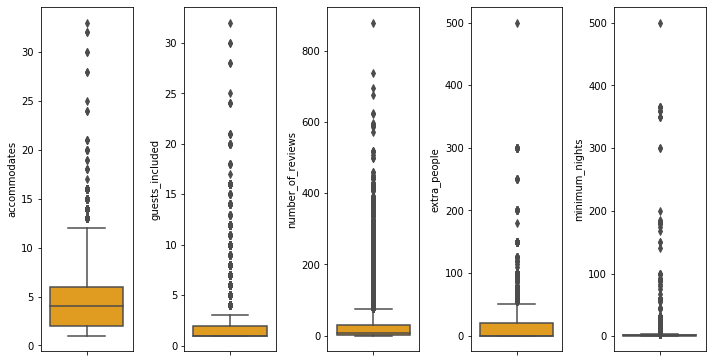

In [41]:
df_numerical = listings[["accommodates", "guests_included", "number_of_reviews", "extra_people", "minimum_nights"]]

l = df_numerical.columns.values
number_of_columns=5
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(10,25))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.boxplot(df_numerical[l[i]],color='orange', orient = 'v')
    plt.tight_layout()

<Figure size 1080x720 with 0 Axes>

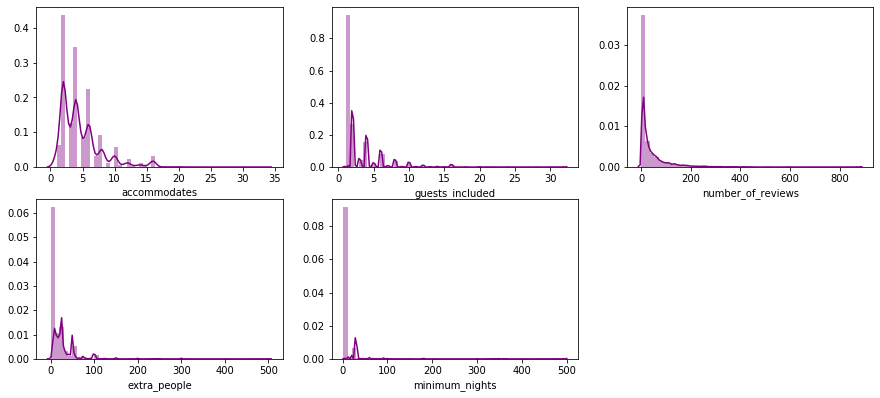

In [42]:
#df1 = df.fillna(df.mean()) #Filling each na value to mean
# only numerical varaible
l = df_numerical.columns.values
number_of_columns=3
number_of_rows = 2
plt.figure(figsize=(15,10))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(df_numerical[l[i]],color='purple')

In [43]:
# Looking at the box blots an dteh distplot, tried to amke the datset beetr by removing the outliers.
# For examples for `accomodates` anything above 20 has been truncated to 20 and so on for other variables.

# accommodates
listings.loc[listings["accommodates"] > 15, 
             "accommodates"] = 15

accommodates = listings["accommodates"]

#guests_included
listings.loc[listings["guests_included"] > 15, 
             "guests_included"] = 15

guests_included = listings["guests_included"]


#number_of_reviews
listings.loc[listings["number_of_reviews"] > 200, 
             "number_of_reviews"] = 200

review_count = listings["number_of_reviews"]

#extra_people
listings.loc[listings["extra_people"] > 100, 
             "extra_people"] = 100

extra_people = listings["extra_people"]

#minimum_nights
listings.loc[listings["minimum_nights"] > 10, 
             "minimum_nights"] = 10

min_nights = listings["minimum_nights"]




<Figure size 720x1800 with 0 Axes>

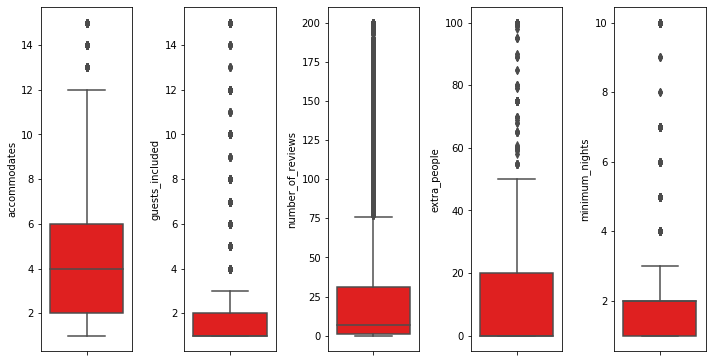

In [44]:
df_numerical = listings[["accommodates", "guests_included", "number_of_reviews", "extra_people", "minimum_nights"]]

l = df_numerical.columns.values
number_of_columns=5
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(10,25))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.boxplot(df_numerical[l[i]],color='red', orient = 'v')
    plt.tight_layout()

<Figure size 1080x720 with 0 Axes>

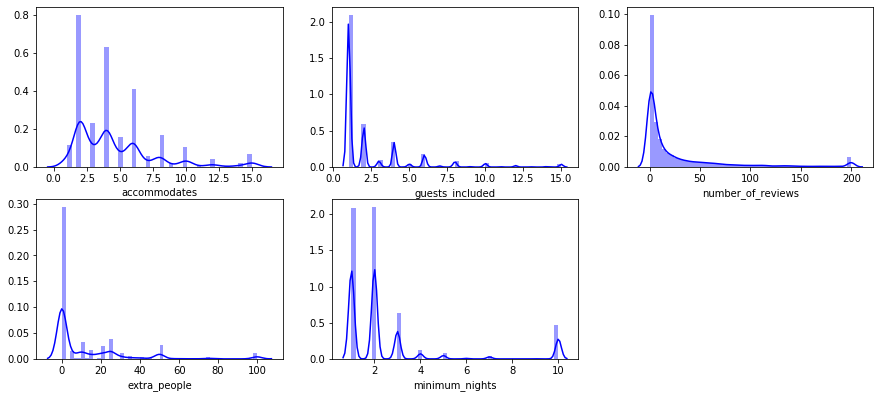

In [45]:
l = df_numerical.columns.values
number_of_columns=3
number_of_rows = 2
plt.figure(figsize=(15,10))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(df_numerical[l[i]],color='blue')

<font size = 5 color= 'green' >  __DataSet- Crimes__ </font>
    
This dataset  provide all the reported crimes in Austin, TX that occurred in 2018 (We could not find the dataset for 2019). 

__`NOTE`__  AirBnb data is for the year 2019 and Crimes data is for the Year 2018.


In [46]:
crimes = pd.read_csv("/Users/nitinmahajan/Desktop/Austin_2019_AirBNB/Austin_Crime_Reports_2018.csv")
for i in range(0, len(crimes.columns), 10):
    columns = crimes.columns[i:i+10]
    display(crimes[columns].head())

,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time
0,201810071,BURGLARY OF RESIDENCE,500,N,12/31/2017 10:40:00 PM,12/31/2017,2240,01/01/2018 12:14:00 AM,01/01/2018,14
1,201811452,VIOL OF PROTECTIVE ORDER,3009,N,01/01/2018 05:47:00 PM,01/01/2018,1747,01/01/2018 05:47:00 PM,01/01/2018,1747
2,201811572,DWI,2100,N,01/01/2018 06:42:00 PM,01/01/2018,1842,01/01/2018 06:42:00 PM,01/01/2018,1842
3,201811906,FAMILY DISTURBANCE,3400,N,01/01/2018 10:53:00 PM,01/01/2018,2253,01/01/2018 10:53:00 PM,01/01/2018,2253
4,201811803,AGG ASSAULT,402,N,01/01/2018 09:34:00 PM,01/01/2018,2134,01/01/2018 09:34:00 PM,01/01/2018,2134


,Location Type,Address,Zip Code,Council District,APD Sector,APD District,PRA,Census Tract,Clearance Status,Clearance Date
0,RESIDENCE / HOME,6212 SPEYSIDE DR,78653.0,1.0,CH,8,226.0,NaN,N,02/15/2018
1,RESIDENCE / HOME,1909 COATS CIR,78748.0,5.0,FR,1,101.0,NaN,C,01/02/2018
2,STREETS / HWY / ROAD / ALLEY,6300 E BEN WHITE BLVD SVRD WB,78741.0,3.0,HE,5,459.0,NaN,C,01/02/2018
3,RESIDENCE / HOME,12300 HYMEADOW DR,78750.0,6.0,AD,6,827.0,NaN,N,01/14/2018
4,CONSTRUCTION SITE,7325 BURNET RD,78757.0,7.0,ID,7,261.0,NaN,N,01/26/2018


,UCR Category,Category Description,X-coordinate,Y-coordinate,Latitude,Longitude,Location
0,220,Burglary,3155773.0,3155773.0,30.365319,-97.608693,"(30.36531857, -97.60869311)"
1,NaN,NaN,3086303.0,3086303.0,30.159176,-97.834375,"(30.15917646, -97.83437467)"
2,NaN,NaN,3124490.0,3124490.0,30.212751,-97.712062,"(30.21275145, -97.71206235)"
3,NaN,NaN,3095390.0,3095390.0,30.454034,-97.797880,"(30.45403435, -97.79788023)"
4,13A,Aggravated Assault,3116167.0,3116167.0,30.349092,-97.734751,"(30.34909179, -97.73475125)"


In [47]:
crimes_info = {"series": crimes.columns, 
               "entry count": [crimes[column].count()
                               for column in crimes.columns], 
               "NaN count": [crimes[column].isna().sum() 
                             for column in crimes.columns], 
               "percent of NaN (%)": [(crimes[column].isna().sum() 
                                       / len(crimes))*100 
                                       for column in crimes.columns],
              "dtypes": [crimes[column].dtypes for column in crimes.columns]}

crimes_info = pd.DataFrame(crimes_info).set_index("series")
for i in range(0, len(crimes_info), 30):
    display(crimes_info.iloc[i:i+30])

,entry count,NaN count,percent of NaN (%),dtypes
series,,,,
Incident Number,102613,0,0.000000,int64
Highest Offense Description,102613,0,0.000000,object
Highest Offense Code,102613,0,0.000000,int64
Family Violence,102613,0,0.000000,object
Occurred Date Time,102613,0,0.000000,object
Occurred Date,102613,0,0.000000,object
Occurred Time,102613,0,0.000000,int64
Report Date Time,102613,0,0.000000,object
Report Date,102613,0,0.000000,object


In [48]:
crimes['Zip Code'].value_counts()

78741.0    8186
78753.0    7898
78758.0    7545
78701.0    7065
78704.0    6502
78745.0    6487
78744.0    5759
78723.0    5631
78702.0    4777
78748.0    3553
78752.0    3530
78759.0    3239
78757.0    2514
78751.0    2503
78705.0    2115
78749.0    1859
78724.0    1839
78721.0    1795
78729.0    1763
78727.0    1611
78703.0    1594
78746.0    1498
78754.0    1288
78750.0    1279
78731.0    1175
78617.0     909
78717.0     871
78735.0     814
78722.0     781
78747.0     739
78756.0     722
78660.0     698
78719.0     653
78726.0     618
78613.0     564
78739.0     305
78736.0     231
78730.0     215
78725.0     171
78653.0     142
78742.0     139
78728.0      54
78652.0      36
78712.0      16
78737.0      10
78732.0      10
78733.0       7
78681.0       5
78738.0       3
78641.0       3
78610.0       3
78664.0       2
78734.0       2
78612.0       1
Name: Zip Code, dtype: int64

In [49]:
#drop all the rows with zipcode NaN values 
crimes_clean= crimes[crimes['Zip Code'].notnull()]

In [50]:
#count the remaing of the rows 
# we can also check shape for this though
print(len(crimes_clean["Zip Code"].isna()))


101729


In [51]:
crimes_clean.shape

(101729, 27)

In [52]:
crimes_clean["Zip Code"].dtype

dtype('float64')

In [53]:
crimes_clean["Zip Code"] = crimes_clean["Zip Code"].astype(int)

/Users/nitinmahajan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [54]:
#check again dtype 
crimes_clean["Zip Code"].dtype

dtype('int64')

In [55]:
crimes_per_zip = crimes_clean.groupby("Zip Code").count()[["Incident Number"]]
crimes_per_zip = crimes_per_zip.sort_values("Incident Number",
                                            ascending=False)

crimes_per_zip.columns = ["Total no. of crimes"]
crimes_per_zip = crimes_per_zip.reset_index()

display(crimes_per_zip.head())

,Zip Code,Total no. of crimes
0,78741,8186
1,78753,7898
2,78758,7545
3,78701,7065
4,78704,6502


In [56]:
major_crimes = crimes_clean.pivot_table(index="Zip Code", 
                                  columns="Category Description", 
                                  values="Incident Number", 
                                  aggfunc="count")
major_crimes = major_crimes.reset_index()
major_crimes.columns.name = None

major_crimes = major_crimes.fillna(0)

display(major_crimes.head())

,Zip Code,Aggravated Assault,Auto Theft,Burglary,Murder,Rape,Robbery,Theft
0,78613,7.0,7.0,9.0,0.0,2.0,8.0,317.0
1,78617,24.0,19.0,52.0,2.0,7.0,5.0,120.0
2,78652,3.0,0.0,0.0,0.0,0.0,1.0,4.0
3,78653,5.0,6.0,6.0,0.0,1.0,1.0,39.0
4,78660,18.0,15.0,23.0,0.0,4.0,1.0,266.0


In [57]:
crimes_clean = pd.merge(crimes_per_zip, major_crimes, 
                        how="outer", on="Zip Code")
crimes_clean = crimes_clean.fillna(0, axis=0)

display(crimes_clean.head())

,Zip Code,Total no. of crimes,Aggravated Assault,Auto Theft,Burglary,Murder,Rape,Robbery,Theft
0,78741,8186,205.0,209.0,350.0,2.0,87.0,137.0,1824.0
1,78753,7898,181.0,177.0,305.0,5.0,53.0,105.0,2055.0
2,78758,7545,163.0,184.0,386.0,4.0,70.0,105.0,1805.0
3,78701,7065,120.0,81.0,82.0,0.0,54.0,76.0,1707.0
4,78704,6502,95.0,195.0,300.0,1.0,37.0,41.0,1924.0


__<font size =3 color= 'blue' > Merging `Listings` and `Crimes` datasets  </font>__

In [58]:
listings_zip = set(listings["zipcode"].unique())
crimes_zip = set(crimes_clean["Zip Code"].unique())

print("Zip codes present in Airbnb listings but not in crimes data:" , 
      listings_zip.difference(crimes_zip))

Zip codes present in Airbnb listings but not in crimes data: {'78731', '78681', '78723', '78719', '78747', '78749', '78721', '78669', '78660', '78732', '78729', '78722', '78767', '78717', '78734', '78727', '78741', '78730', '78704', '78759', '78757', '78737', '78613', '78753', '78739', '78728', '78751', '78756', '78701', '78748', '78744', '78745', '78620', '78652', '78725', '78712', '78619', '78738', '78754', '78736', '78726', '78742', '78746', '78735', '78703', '78653', '78705', '78750', '78752', '78702', '78733', '78724', '78758'}


In [59]:
listings['zipcode'].dtype

dtype('O')

In [60]:
crimes_clean['Zip Code'].dtype

dtype('int64')

In [61]:
listings['zipcode']= listings['zipcode'].astype(int)

In [62]:
listings['zipcode'].dtype

dtype('int64')

In [63]:
listings_clean = pd.merge(listings, crimes_clean, how="left", 
                          left_on="zipcode", right_on="Zip Code")

In [64]:
columns = ["id", "price", "zipcode", "host_is_superhost", 
           "host_verifications_count", "host_identity_verified", 
           "property_type (simple)", "room_type", "cancellation_policy", 
           "Private Entry", "Pets OK", 
           "Self Check-in", "accommodates", 
           "guests_included", "extra_people", "minimum_nights", 
           "number_of_reviews", "Total no. of crimes", 
           "Aggravated Assault", "Auto Theft", "Burglary", 
           "Murder", "Rape", "Robbery", "Theft"]

df = listings_clean[columns]

for i in range(0, len(df.columns), 10):
    columns = df.columns[i:i+10]
    display(df[columns].head())

,id,price,zipcode,host_is_superhost,host_verifications_count,host_identity_verified,property_type (simple),room_type,cancellation_policy,Private Entry
0,2265,$225.00,78702,1,5,1,House,Entire home/apt,strict_14_with_grace_period,1
1,5245,$100.00,78702,1,5,1,House,Private room,strict_14_with_grace_period,0
2,5456,$95.00,78702,1,4,1,Other,Entire home/apt,strict_14_with_grace_period,1
3,5769,$40.00,78729,1,6,1,House,Private room,moderate,0
4,6413,$99.00,78704,1,8,0,Other,Entire home/apt,strict_14_with_grace_period,0


,Pets OK,Self Check-in,accommodates,guests_included,extra_people,minimum_nights,number_of_reviews,Total no. of crimes,Aggravated Assault,Auto Theft
0,1,1,4,4,30.0,10,24,4777.0,106.0,121.0
1,1,0,2,2,35.0,10,9,4777.0,106.0,121.0
2,1,0,3,2,45.0,2,200,4777.0,106.0,121.0
3,1,0,2,2,0.0,1,200,1763.0,30.0,44.0
4,1,0,2,2,25.0,3,104,6502.0,95.0,195.0


,Burglary,Murder,Rape,Robbery,Theft
0,212.0,0.0,29.0,72.0,1187.0
1,212.0,0.0,29.0,72.0,1187.0
2,212.0,0.0,29.0,72.0,1187.0
3,56.0,1.0,7.0,10.0,471.0
4,300.0,1.0,37.0,41.0,1924.0


In [65]:
print("Total entries prior to dropping NaNs:" ,
      len(df))
print("Total entries after dropping NaNs: " ,
      len(df.dropna(axis=0)))

df = df.dropna(axis=0)

Total entries prior to dropping NaNs: 11156
Total entries after dropping NaNs:  11150


___

__<font size =4 color= 'red' > Dependent Variable - 'PRICE' </font>__

As mentioned earlier that aim of this analysis is to predict the nightly rate. 

Let explore the dependent variable - `Price`

In [66]:
listings["price"].head(10)

0    $225.00
1    $100.00
2     $95.00
3     $40.00
4     $99.00
5    $129.00
6    $300.00
7    $550.00
8    $220.00
9    $155.00
Name: price, dtype: object

In [67]:
listings["price"].dtype

dtype('O')

In [68]:
listings["price"].min()

'$0.00'

In [69]:
sorted_df = df.sort_values("price", ascending=False)
display(sorted_df[["price"]].head(10))

,price
5497,$999.00
6790,$999.00
6533,$999.00
6532,$999.00
6531,$999.00
6530,$999.00
5498,$999.00
5499,$999.00
5500,$999.00
5501,$999.00


In [70]:
sorted_df = df.sort_values("price", ascending=True)
display(sorted_df[["price"]].head(10))

,price
5272,$0.00
4733,$0.00
4751,$0.00
4819,$0.00
219,$0.00
4832,$0.00
7618,"$1,000.00"
3788,"$1,000.00"
3951,"$1,000.00"
3975,"$1,000.00"


Major points to consider

- Entries are expressed with the dollor sign e.g. $5000

- dtype is listed as object. 

- The `min` is  `$0`, not sure why is this, but could be some credits is given to the buyers, or some rewards or mistake. # Remove the values with `$0` rows.  (There are actually 6 rows)

- Max price is `$17999`  obvioulsy an outlier. 


In [71]:
price = df["price"].apply(lambda row: row[1:])
price = price.apply(lambda row: "".join(row.split(",")))
price = price.astype(float)

df["price"] = price

In [72]:
display(df[df["price"] == 0][["id", "price", "zipcode", 
                              "property_type (simple)", "room_type", 
                              "number_of_reviews"]])

,id,price,zipcode,property_type (simple),room_type,number_of_reviews
219,377391,0.0,78704,House,Entire home/apt,1
4733,20269052,0.0,78701,Condominium,Private room,0
4751,20320755,0.0,78704,House,Entire home/apt,11
4819,20481189,0.0,78744,House,Shared room,9
4832,20541331,0.0,78704,House,Private room,2
5272,21378172,0.0,78704,House,Entire home/apt,13


In [73]:
df = df[df["price"] != 0]

print("Total 'df' entries: ",  len(df))

Total 'df' entries:  11144


In [74]:
df.head(3)

,id,price,zipcode,host_is_superhost,host_verifications_count,host_identity_verified,property_type (simple),room_type,cancellation_policy,Private Entry,...,minimum_nights,number_of_reviews,Total no. of crimes,Aggravated Assault,Auto Theft,Burglary,Murder,Rape,Robbery,Theft
0,2265,225.0,78702,1,5,1,House,Entire home/apt,strict_14_with_grace_period,1,...,10,24,4777.0,106.0,121.0,212.0,0.0,29.0,72.0,1187.0
1,5245,100.0,78702,1,5,1,House,Private room,strict_14_with_grace_period,0,...,10,9,4777.0,106.0,121.0,212.0,0.0,29.0,72.0,1187.0
2,5456,95.0,78702,1,4,1,Other,Entire home/apt,strict_14_with_grace_period,1,...,2,200,4777.0,106.0,121.0,212.0,0.0,29.0,72.0,1187.0


[Text(0.5, 1.0, " 'Price' Series (Violin Plot)")]

[Text(0.5, 1.0, "'Price' Series (Boxplot) ")]

[Text(0.5, 1.0, "'Price' Series (Distplot)")]

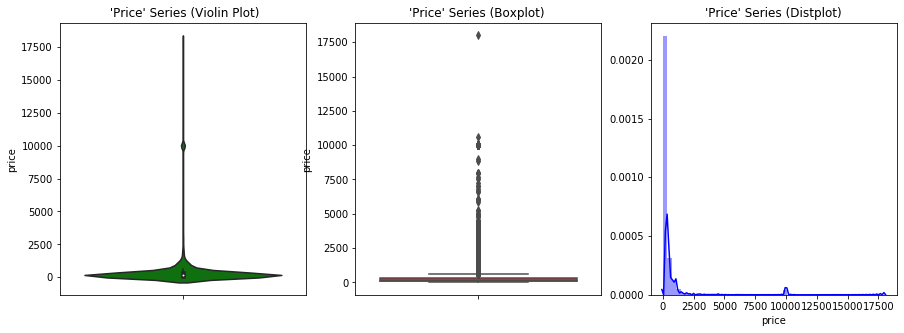

In [75]:
price = df["price"]

f, axes = plt.subplots(1, 3, figsize=(15,5))
ax = sns.violinplot(y=price, ax=axes[0], color="green")
ax.set(title=" 'Price' Series (Violin Plot)")

ax = sns.boxplot(y=price, ax=axes[1], color="red")
ax.set(title="'Price' Series (Boxplot) ")

ax = sns.distplot(price, ax=axes[2], color="blue")
ax.set(title="'Price' Series (Distplot)")

plt.show()

Looking at the boxplot and violenplot for the variable price and outliers, the cutoff we set here is `$750`

[Text(0.5, 1.0, " 'Price' Series (Violin Plot)")]

[Text(0.5, 1.0, "'Price' Series (BoxPlot)")]

[Text(0.5, 1.0, "'Price' Series (Distplot)")]

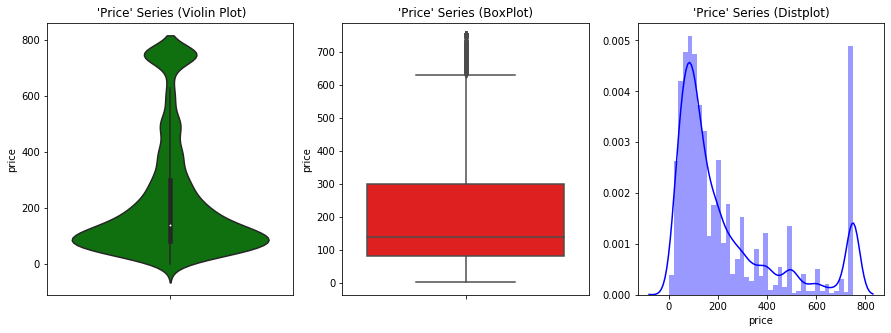

In [76]:
df.loc[df["price"] > 750, "price"] = 750
price = df["price"]

f, axes = plt.subplots(1, 3, figsize=(15,5))
ax = sns.violinplot(y=price, ax=axes[0], color="green")
ax.set(title=" 'Price' Series (Violin Plot)")

ax = sns.boxplot(y=price, ax=axes[1], color="red")
ax.set(title="'Price' Series (BoxPlot)")

ax = sns.distplot(price, ax=axes[2], color="blue")
ax.set(title="'Price' Series (Distplot)")

plt.show()

---

<font size =3 color = 'green' > Stats </font>

Here the `Price` variable has been explored in a similar way we explored other varibale in the EDA section , like room type, amenities, cancelation plocies, pet friendly or not etc. 

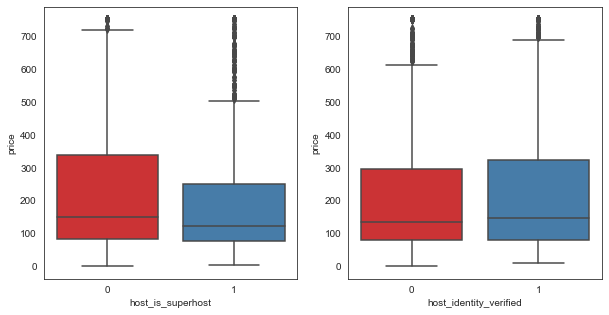

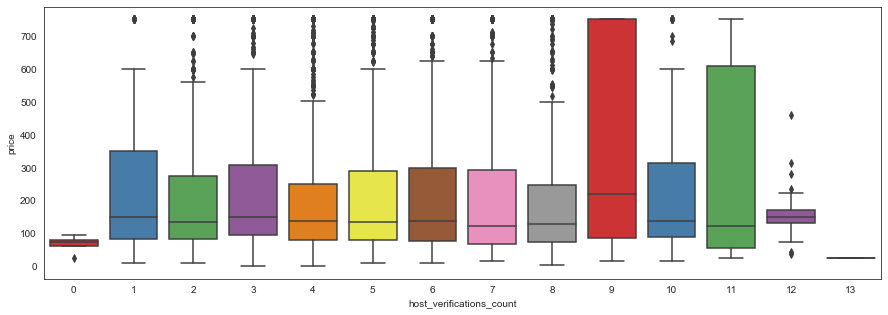

In [77]:
sns.set_style("white")

f, axes = plt.subplots(1, 2, figsize=(10,5))
ax = sns.boxplot(data=df, x="host_is_superhost", y="price", 
                 palette="Set1", ax=axes[0])

ax = sns.boxplot(data=df, x="host_identity_verified", y="price", 
                 palette="Set1", ax=axes[1])

plt.show()

f, axes = plt.subplots(figsize=(15,5))
ax = sns.boxplot(data=df, x="host_verifications_count", y="price", 
                 palette="Set1")

plt.show()

In [78]:
# Lets do the log transformation of the price to getter better idea

[None]

[None]

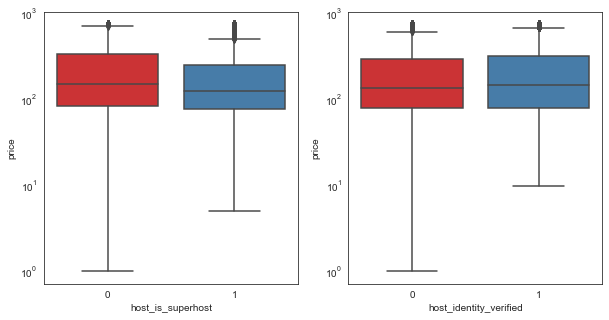

[None]

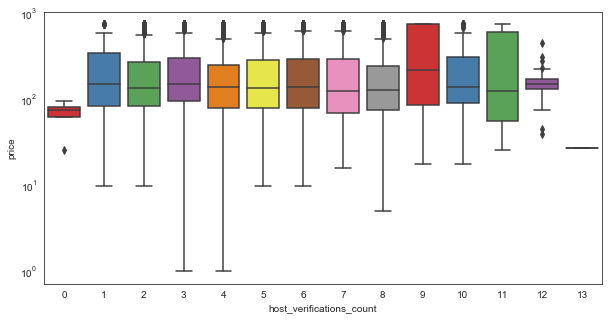

In [79]:
sns.set_style("white")

f, axes = plt.subplots(1, 2, figsize=(10,5))
ax = sns.boxplot(data=df, x="host_is_superhost", y="price", 
                 palette="Set1", ax=axes[0])
ax.set(yscale="log")
ax = sns.boxplot(data=df, x="host_identity_verified", y="price", 
                 palette="Set1", ax=axes[1])
ax.set(yscale="log")
plt.show()

f, axes = plt.subplots(figsize=(10,5))
ax = sns.boxplot(data=df, x="host_verifications_count", y="price", 
                 palette="Set1")
ax.set(yscale="log")
plt.show()

__<font size =4 color= 'blue' > Inference : </font>__ As we can see that host variable is not got predcitor or the price as there is very less variablity.

___

[None]

[None]

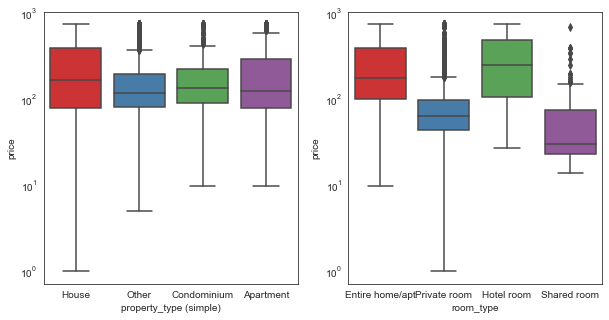

[None]

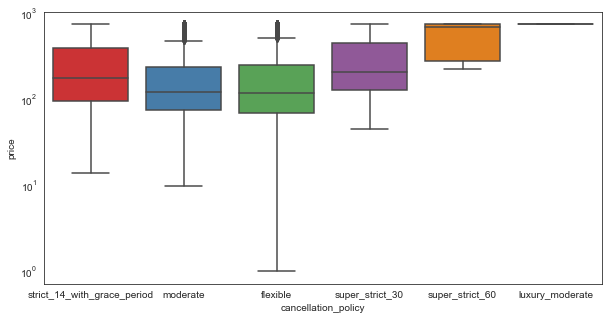

In [80]:
f, axes = plt.subplots(1, 2, figsize=(10,5))
ax = sns.boxplot(data=df, x="property_type (simple)", y="price", 
                 palette="Set1", ax=axes[0])
ax.set(yscale="log")
ax = sns.boxplot(data=df, x="room_type", y="price", 
                 palette="Set1", ax=axes[1])
ax.set(yscale="log")
plt.show()

f, axes = plt.subplots(figsize=(10,5))
ax = sns.boxplot(data=df, x="cancellation_policy", y="price", 
                 palette="Set1")
ax.set(yscale="log")
plt.show()

__<font size =4 color= 'blue' > Inference : </font>__ 1. Entire home or hotel room type can be good candidates for the model . 

2. Also, strict cancelation policies listings have high number 

[None]

[None]

[None]

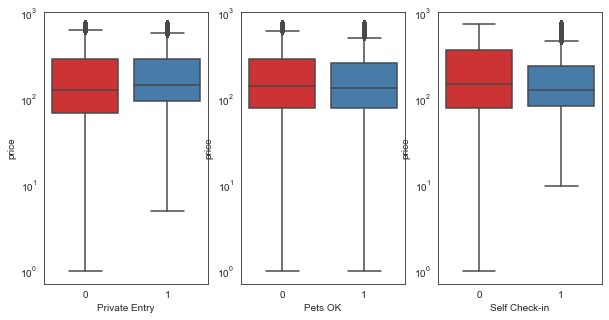

In [81]:
f, axes = plt.subplots(1, 3, figsize=(10,5))

ax = sns.boxplot(data=df, x="Private Entry", y="price", 
                 palette="Set1", ax=axes[0])
ax.set(yscale="log")

ax = sns.boxplot(data=df, x="Pets OK", y="price", 
                 palette="Set1", ax=axes[1])
ax.set(yscale="log")

ax = sns.boxplot(data=df, x="Self Check-in", y="price", 
                 palette="Set1", ax=axes[2])
ax.set(yscale="log")

plt.show()

__<font size =4 color= 'blue' > Inference : </font>__

`Private entry` and `self check in` properties seem to be bit costlier.  

[None]

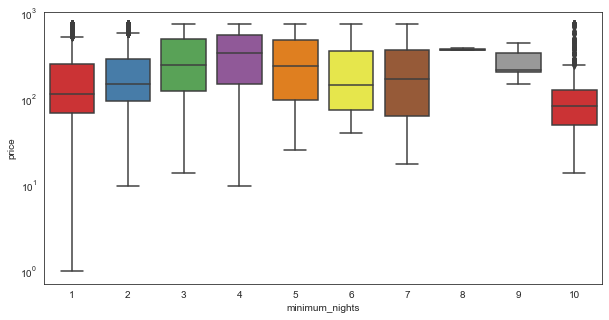

In [82]:
f, axes = plt.subplots(figsize=(10,5))
ax = sns.boxplot(data=df, x="minimum_nights", y="price", 
                 palette="Set1")
ax.set(yscale="log")
plt.show()

__<font size =4 color= 'blue' > Inference : </font>__
    
One would assume that, less number of night stays will make it expensive, but looking at the boxplot doesnt seens that way. Till 4-5 nights price seems almost same.   

[None]

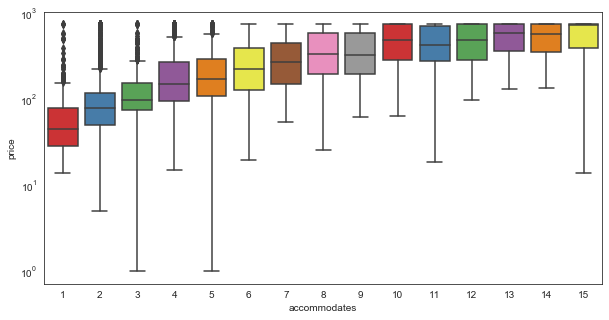

[None]

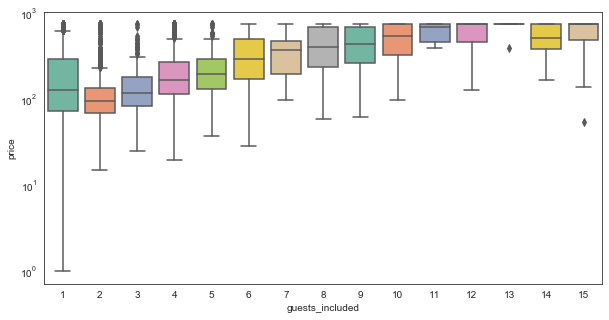

In [83]:
f, axes = plt.subplots(1, 1, figsize=(10,5))
ax = sns.boxplot(data=df, x="accommodates", y="price", 
                 palette="Set1")
ax.set(yscale="log")
plt.show()

f, axes = plt.subplots(1, 1, figsize=(10,5))
ax = sns.boxplot(data=df, x="guests_included", y="price", 
                 palette="Set2")
ax.set(yscale="log")
plt.show()

__<font size =4 color= 'blue' > Inference : </font>__

1. The accommodates and the guests_included features both can give us sense about the pricing.

2. Less number of persons goes well with the cheaper price 

3. Price is also increases with the higher of guests, and are therefore more expensive.

__<font size =5 color = 'green' > Real Analysis - Inferential Statistics </font>__

Final dataframe we will be using for analysis had been named as df ealier hand have 25 coulmns. Below is an overview of the final data. 

In [84]:
df.shape

(11144, 25)

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11144 entries, 0 to 11155
Data columns (total 25 columns):
id                          11144 non-null int64
price                       11144 non-null float64
zipcode                     11144 non-null int64
host_is_superhost           11144 non-null int64
host_verifications_count    11144 non-null int64
host_identity_verified      11144 non-null int64
property_type (simple)      11144 non-null object
room_type                   11144 non-null object
cancellation_policy         11144 non-null object
Private Entry               11144 non-null int64
Pets OK                     11144 non-null int64
Self Check-in               11144 non-null int64
accommodates                11144 non-null int64
guests_included             11144 non-null int64
extra_people                11144 non-null float64
minimum_nights              11144 non-null int64
number_of_reviews           11144 non-null int64
Total no. of crimes         11144 non-null float64


In [86]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,11144.0,2.169683e+07,1.211807e+07,2265.0,11473896.0,22504783.0,32517905.0,40063065.0
price,11144.0,2.319110e+02,2.177255e+02,1.0,80.0,140.0,300.0,750.0
zipcode,11144.0,7.872218e+04,2.069893e+01,78613.0,78704.0,78721.0,78744.0,78759.0
host_is_superhost,11144.0,3.589375e-01,4.797104e-01,0.0,0.0,0.0,1.0,1.0
host_verifications_count,11144.0,5.453248e+00,2.192349e+00,0.0,4.0,5.0,7.0,13.0
host_identity_verified,11144.0,4.960517e-01,5.000068e-01,0.0,0.0,0.0,1.0,1.0
Private Entry,11144.0,4.029971e-01,4.905222e-01,0.0,0.0,0.0,1.0,1.0
Pets OK,11144.0,2.657933e-01,4.417745e-01,0.0,0.0,0.0,1.0,1.0
Self Check-in,11144.0,4.284817e-01,4.948809e-01,0.0,0.0,0.0,1.0,1.0
accommodates,11144.0,4.646447e+00,3.073350e+00,1.0,2.0,4.0,6.0,15.0


From a personal experince, when I look for hotel or room at websites like AirBnb, apart fom price the first think I look is the `Reviews`. 

So, lets see what is equation here between `price` and `reviews`.

- First we have to check presence or absnece of homogeneity of variance (homo or hetero scedasticity)

- Perform Levene test

In [87]:
alpha = 0.05 # set alpha 

stat, p = stats.levene(df["number_of_reviews"], df["price"])
print("Levene W: " , stat)
print("P-Value: \n", p)
print("P-Value larger than alpha? ", str(p > alpha))

if p > alpha:
    print("do NOT reject null hypothesis")
else:
    print("Reject null hypothesis")

Levene W:  5073.354797367289
P-Value: 
 0.0
P-Value larger than alpha?  False
Reject null hypothesis


__<font size =4 color= 'blue' > Inference : </font>__
    
Rejecting null hyopthesis above means the data fails the variance homogeneity assumption an dtherefore for corletion analysis we will use `Spearman Rank`, instead of Pearson Correlation. 

Text(0.5, 1.0, 'Total number of reviews vs Price')

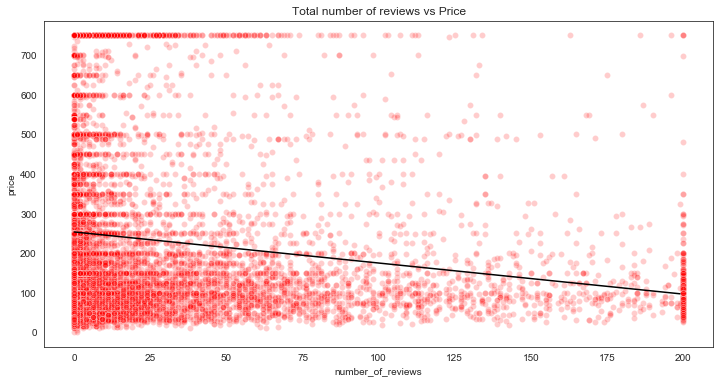

In [88]:
f, axes = plt.subplots(figsize=(12,6))

ax = sns.scatterplot(x="number_of_reviews", y="price", 
                data=df, alpha=0.2, color = 'red')
m, b = np.polyfit(df["number_of_reviews"], df["price"], 1)
reg_x = np.arange(0, max(df["number_of_reviews"]))
reg_y = m * reg_x + b
ax = sns.lineplot(reg_x, reg_y, color="black")
plot_title = "Total number of reviews" + " vs Price"
ax.set_title(plot_title)
plt.show()

In [89]:
### Spearman Rank
## Mention the cor method
print("Spearman Rank")
display(df[["price", "number_of_reviews"]].corr(method="spearman"))  #method

Spearman Rank


,price,number_of_reviews
price,1.00000,-0.21123
number_of_reviews,-0.21123,1.00000


__<font size =4 color= 'blue' > Inference : </font>__
    
Scatter plot for the price and number_of_reviews and best fit line, clearly shows a negative correlation but looking at the value (-0.211), the association is considered weak.

In [90]:
df["Total no. of crimes"].head()

0    4777.0
1    4777.0
2    4777.0
3    1763.0
4    6502.0
Name: Total no. of crimes, dtype: float64

In [91]:
df["Total no. of crimes"].dtypes

dtype('float64')

In [92]:
df.iloc[0]

id                                                 2265
price                                               225
zipcode                                           78702
host_is_superhost                                     1
host_verifications_count                              5
host_identity_verified                                1
property_type (simple)                            House
room_type                               Entire home/apt
cancellation_policy         strict_14_with_grace_period
Private Entry                                         1
Pets OK                                               1
Self Check-in                                         1
accommodates                                          4
guests_included                                       4
extra_people                                         30
minimum_nights                                       10
number_of_reviews                                    24
Total no. of crimes                             

Text(0.5, 1.0, 'Aggravated Assault vs. Price')

Text(0.5, 1.0, 'Auto Theft vs. Price')

Text(0.5, 1.0, 'Burglary vs. Price')

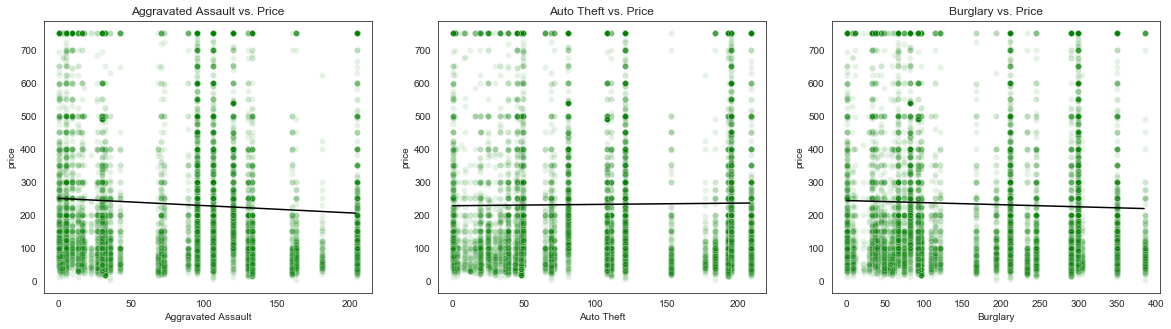

Text(0.5, 1.0, 'Rape vs. Price')

Text(0.5, 1.0, 'Robbery vs. Price')

Text(0.5, 1.0, 'Theft vs. Price')

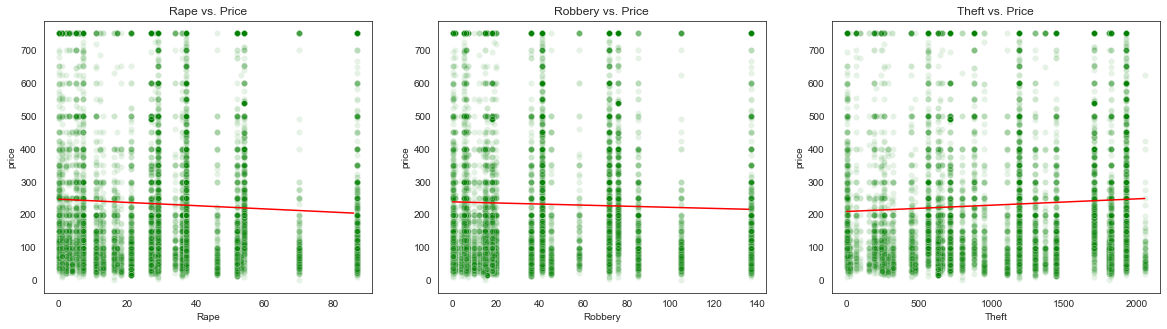

In [93]:
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
continuous = ["Aggravated Assault", "Auto Theft", "Burglary"]
for i in range(3):
    ax = sns.scatterplot(x=df[continuous[i]],
                         y=df["price"],
                         data=df,
                         alpha=0.1,
                         color='green',
                         ax=axes[i])
    m, b = np.polyfit(df[continuous[i]], df["price"], 1)
    reg_x = np.arange(0, max(df[continuous[i]]))
    reg_y = m * reg_x + b
    ax = sns.lineplot(reg_x, reg_y, color="black", ax=axes[i])
    plot_title = continuous[i] + " vs. Price"
    ax.set_title(plot_title)
plt.show()

f, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
continuous = ["Rape", "Robbery", "Theft"]
for i in range(3):
    ax = sns.scatterplot(x=df[continuous[i]],
                         y=df["price"],
                         data=df,
                         alpha=0.1,
                         color='green',
                         ax=axes[i])
    m, b = np.polyfit(df[continuous[i]], df["price"], 1)
    reg_x = np.arange(0, max(df[continuous[i]]))
    reg_y = m * reg_x + b
    ax = sns.lineplot(reg_x, reg_y, color="red", ax=axes[i])
    plot_title = continuous[i] + " vs. Price"
    ax.set_title(plot_title)
plt.show()

In [94]:
print("Spearman Matrix")

continuous = [
    "Aggravated Assault", "Auto Theft", "Burglary", "Rape", "Robbery", "Theft"
]

corr = df[["price", *continuous]].corr(method="spearman")

corr.style.background_gradient(cmap='Oranges')

Spearman Matrix


,price,Aggravated Assault,Auto Theft,Burglary,Rape,Robbery,Theft
price,1,-0.0523359,0.0395525,-0.041209,-0.00235254,0.0117226,0.0875579
Aggravated Assault,-0.0523359,1,0.742394,0.760151,0.902578,0.922203,0.696817
Auto Theft,0.0395525,0.742394,1,0.95189,0.848186,0.72135,0.910328
Burglary,-0.041209,0.760151,0.95189,1,0.827999,0.72493,0.874652
Rape,-0.00235254,0.902578,0.848186,0.827999,1,0.846546,0.85649
Robbery,0.0117226,0.922203,0.72135,0.72493,0.846546,1,0.704082
Theft,0.0875579,0.696817,0.910328,0.874652,0.85649,0.704082,1


<font size =4 color = 'green' > Price and Location </font>

Zipcode provides the information about the location. A appropriate significance test to check the significance in of categorical features, we need to check the normality of the data set  and we can run Shapiro Wilk test. However, the accuracy for its p-value if the data contains 5,000 samples, as in the case of our dataset. So we'll opt to use the __Kolmogorov-Smirnov__ test instead.

We want to be able to find out if price follows a normal distribution.

__Null Hypothesis__: The price curve is normal

__Alternative Hypothesis__: The price curve is NOT normal

In [95]:
mean = np.mean(df["price"])
std = np.std(df["price"])

stat, p = stats.kstest(df["price"], "norm", args=(mean, std))

print("KS-Statistic: ", stat)
print("P-Value: ", p)
print("P-Value larger than alpha?", str(p > alpha))

if p > alpha:
    print("Price Curve appears Normal - do NOT reject null hypothesis")
else:
    print("Price Curve does NOT appear Normal- Reject null hypothesis")

KS-Statistic:  0.2121594691180237
P-Value:  0.0
P-Value larger than alpha? False
Price Curve does NOT appear Normal- Reject null hypothesis


__<font size =4 color= 'blue' > Inference : </font>__

p-value is significantly smaller than our critical value of 0.05, suggesting we cannot therefore assume normality and have to use __`nonparametric statistical tests`__

We'll use __`Kruskal-Wallis test`__ because it's the nonparametric analog to ANOVA testing. This test is suited for variables with `multiple discrete categories`, as in the case for zipcode.

In [96]:
variables = ""
for index, count in enumerate(df["zipcode"].unique()):
    exec("data" + str(index) + "= df[df['zipcode']== " + str(count) +
         "]['price']")
    variables = variables + "data" + str(index) + ", "
variables = variables[:-2]

exec("stat, p = stats.kruskal(" + variables + ")")
print("Zip Code", "\n**************")
print("Number of variables:" , (index + 1))
print("Kruskal-Wallis H: " , stat)
print("P-Value: %f" , p)
print("P-Value larger than alpha?" , str(p > alpha))

if p > alpha:
    print("Distributions are the same - do NOT reject null hypothesis")
else:
    print("Distributions are NOT the same - Reject null hypothesis")

Zip Code 
**************
Number of variables: 49
Kruskal-Wallis H:  1693.161987940456
P-Value: %f 0.0
P-Value larger than alpha? False
Distributions are NOT the same - Reject null hypothesis


__<font size =4 color= 'blue' > Inference : </font>__

The p-value is low and so we reject our null hypothesis and conclude that the distributions for zipcode are not similar, therefore making `zipcode` a good feature for our predictive model.


In [97]:
categories = [
    "host_is_superhost", "host_identity_verified", "Private Entry", "Pets OK",
    "Self Check-in"
]

for category in categories:
    data0 = df[df[category] == 0]["price"]
    data1 = df[df[category] == 1]["price"]

    stat, p = stats.mannwhitneyu(data0, data1)
    print(category, "\n******************")
    print("Mann-Whitney U: %.3f" % stat)
    print("P-Value: %f" % p)
    print("P-Value larger than alpha?" ,str(p > alpha))

    if p > alpha:
        print("Distribution is the same - do NOT reject null hypothesis")
    else:
        print("Distribution is NOT the same - Reject null hypothesis")

host_is_superhost 
******************
Mann-Whitney U: 12861543.500
P-Value: 0.000000
P-Value larger than alpha? False
Distribution is NOT the same - Reject null hypothesis
host_identity_verified 
******************
Mann-Whitney U: 15054429.000
P-Value: 0.002902
P-Value larger than alpha? False
Distribution is NOT the same - Reject null hypothesis
Private Entry 
******************
Mann-Whitney U: 13482932.500
P-Value: 0.000000
P-Value larger than alpha? False
Distribution is NOT the same - Reject null hypothesis
Pets OK 
******************
Mann-Whitney U: 11703676.500
P-Value: 0.002890
P-Value larger than alpha? False
Distribution is NOT the same - Reject null hypothesis
Self Check-in 
******************
Mann-Whitney U: 13893092.500
P-Value: 0.000000
P-Value larger than alpha? False
Distribution is NOT the same - Reject null hypothesis


In [98]:
categories = ["host_verifications_count", "property_type (simple)", 
              "room_type", "cancellation_policy", "accommodates", 
              "guests_included", "extra_people", "minimum_nights", "Murder"]

for category in categories:
    series = eval("df['" + category + "']")
    cat_str = category
    variables = ""
    for index, count in enumerate(series.unique()):
        if type(count) == str:
            count = "'" + count + "'"
        exec("data" + str(index) + "= df[df['" + cat_str + "']== " + 
             str(count) + "]['price']")
        variables = variables + "data" + str(index) + ", "
    variables = variables[:-2]

    exec("stat, p = stats.kruskal(" + variables + ")")
    print(cat_str, "\n*****************")
    print("Number of variables:" , (index+1))
    print("Kruskal-Wallis H: " , stat)
    print("P-Value: " ,p)
    print("P-Value larger than alpha? " , str(p > alpha))

    if p > alpha:
        print("Distributions are the same - do NOT reject null hypothesis")
    else:
        print("Distributions are NOT the same - Reject null hypothesis")

host_verifications_count 
*****************
Number of variables: 14
Kruskal-Wallis H:  148.5129462224665
P-Value:  4.1074629081683e-25
P-Value larger than alpha?  False
Distributions are NOT the same - Reject null hypothesis
property_type (simple) 
*****************
Number of variables: 4
Kruskal-Wallis H:  101.5029994757217
P-Value:  7.384147212461042e-22
P-Value larger than alpha?  False
Distributions are NOT the same - Reject null hypothesis
room_type 
*****************
Number of variables: 4
Kruskal-Wallis H:  2973.4691638035956
P-Value:  0.0
P-Value larger than alpha?  False
Distributions are NOT the same - Reject null hypothesis
cancellation_policy 
*****************
Number of variables: 6
Kruskal-Wallis H:  497.94160702449693
P-Value:  2.221028912749492e-105
P-Value larger than alpha?  False
Distributions are NOT the same - Reject null hypothesis
accommodates 
*****************
Number of variables: 15
Kruskal-Wallis H:  4399.164285771908
P-Value:  0.0
P-Value larger than alpha? 

__<font size =4 color= 'blue' > Inference : </font>__

Now we have a better understanding of how well each feature may predict the nightly rate of an Airbnb listing in Austin, TX for the year 2019. We wil now create a  predictive model to address out major question.  

__<font size = 5 color ='blue' > In Depth Analysis - Machine Learning </font>__

`Encoding`- One-hot encoding on the categorical features of our df dataframe. This will stretche our categorical columns so we have one column per category. Note: Keep in mind zip code is expressed in digitd but actully a multi-catrgpry categorical data. Converting zipcdoe to category type also helps make the computations faster.

We assign our X and y variables based on the new_df – the modified df where get dummies was applied. We predict the y – our price – given the X features.

As we know the output, we will be running different supervised machine learning approaches to find out what estimator works most effectively without tuning. Once that's been figured out, we can then perform `hyperparameter tuning`. The metric used is the mean R2 for accuracy over 5-fold cross-validation.

The train-test split will be in a ratio of 80% and 20% respectivly. 


1. Linear regression 
2. Ridge Regression
3. Lasso Regression 
4. Decision Tree
5. Random Forest 
6. Bagging Regressor
7. Adaptive Boost Regressor 
8. Gradient Boost Regressor 
9. Support Vector Machine 
10. Basic Neural Network



In [99]:
categories = ["zipcode", "host_is_superhost", "host_verifications_count", 
              "host_identity_verified", "property_type (simple)", "room_type", 
              "cancellation_policy", "Private Entry", 
              "Pets OK", "Self Check-in", "minimum_nights"]
for category in categories:
    df[category] = df[category].astype("category")

new_df = pd.get_dummies(df, drop_first=True)

X = new_df.drop(columns=["id", "price"])
y = np.log(new_df[["price"]])

__<font size = 4 color ='blue' > Linear Regression </font>__

In [100]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)

cross_val_scores= cross_val_score(reg, X_train, y_train, 
                                  cv=5, scoring="r2")*100
scores = {}
scores["Linear Regression"] = np.mean(cross_val_scores)

print("Linear Regression Cross-Validation Scores:")
for score in cross_val_scores:
    print("" ,score)
print("Average Score on 5-Folds: " ,
     scores["Linear Regression"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Linear Regression Cross-Validation Scores:
 57.57104152594468
 56.45059175504981
 57.35876012685128
 58.092217402573645
 53.373965200929355
Average Score on 5-Folds:  56.56931520226975


__<font size = 5 color ='blue' > Ridge Regression </font>__

In [101]:
from sklearn.linear_model import Ridge

ridge = Ridge(random_state=42)
ridge.fit(X_train, y_train)

cross_val_scores = cross_val_score(ridge, X_train, y_train, 
                                   cv=5, scoring="r2")*100
scores["Ridge Regression"] = np.mean(cross_val_scores)

print("Ridge Regression Cross-Validation Scores:")
for score in cross_val_scores:
    print(" " , score)
print("Average Score on 5-Folds: " ,
     scores["Ridge Regression"])

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001)

Ridge Regression Cross-Validation Scores:
  57.61391351725693
  56.48837884205571
  57.30491933664484
  58.06514867660291
  53.33232471475306
Average Score on 5-Folds:  56.560937017462685


__<font size = 5 color ='blue' > Lasso </font>__

In [102]:
from sklearn.linear_model import Lasso

lasso = Lasso(random_state=42)
lasso.fit(X_train, y_train)

cross_val_scores = cross_val_score(lasso, X_train, y_train, 
                                   cv=5, scoring="r2")*100
scores["Lasso Regression"] = np.mean(cross_val_scores)

print("Lasso Regression Cross-Validation Scores:")
for score in cross_val_scores:
    print(" ", score)
print("Average Score on 5-Folds: " , 
     scores["Lasso Regression"])

#ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations.
#Fitting data with very small alpha may cause precision problems.

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)

Lasso Regression Cross-Validation Scores:
  28.05156844444755
  28.099268934953248
  28.065331049432906
  27.596181601446524
  27.431850834798478
Average Score on 5-Folds:  27.848840173015738


__<font size = 5 color ='blue' > Decision Tree </font>__

In [103]:
from sklearn import tree

trees = tree.DecisionTreeRegressor(max_depth=6, random_state=42)
trees.fit(X_train, y_train)

cross_val_scores = cross_val_score(trees, X_train, y_train, 
                                   cv=5, scoring="r2")*100
scores["Decision Tree"] = np.mean(cross_val_scores)

print("Decision Tree Cross-Validation Scores:")
for score in cross_val_scores:
    print(" " , score)
print("Average Score on 5-Folds: " , 
     scores["Decision Tree"])

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

Decision Tree Cross-Validation Scores:
  53.96560184174535
  56.005246732369706
  57.42148842522572
  56.56638267726035
  50.876920955084294
Average Score on 5-Folds:  54.96712812633708


__<font size = 5 color ='blue' > Random Forrest </font>__

In [104]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, np.ravel(y_train))

cross_val_scores = cross_val_score(forest, X_train, 
                                   np.ravel(y_train), 
                                   cv=5, scoring="r2")*100
scores["Random Forest"] = np.mean(cross_val_scores)

print("Random Forest Cross-Validation Scores:")
for score in cross_val_scores:
    print(" " , score)
print("Average Score on 5-Folds: " , 
     scores["Random Forest"])


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Random Forest Cross-Validation Scores:
  62.869171465109744
  65.09969621786567
  66.65826532149195
  66.42600799578238
  61.23816303569101
Average Score on 5-Folds:  64.45826080718815


__<font size = 5 color ='blue' > Bagging Regressor </font>__

In [105]:
from sklearn.ensemble import BaggingRegressor

bag = BaggingRegressor(base_estimator=trees, 
                       random_state=42)
bag.fit(X_train, np.ravel(y_train))

cross_val_scores = cross_val_score(bag, X_train, 
                                   np.ravel(y_train), 
                                   cv=5, scoring="r2")*100
scores["Bagging Tree"] = np.mean(cross_val_scores)

print("Bagging Tree Cross-Validation Scores:")
for score in cross_val_scores:
    print(" " , score)
print("Average Score on 5-Folds:" , 
     scores["Bagging Tree"])

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

Bagging Tree Cross-Validation Scores:
  57.78782214671314
  60.95775888061645
  61.452829268443686
  60.902150394472656
  55.08021885604721
Average Score on 5-Folds: 59.23615590925863


__<font size = 5 color ='blue' > Adaptive Boosting Regressor </font>__

In [106]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(base_estimator=trees, random_state=42)
ada.fit(X_train, np.ravel(y_train))

cross_val_scores = cross_val_score(ada, X_train, 
                                   np.ravel(y_train), 
                                   cv=5, scoring="r2")*100
scores["AdaBoost"] = np.mean(cross_val_scores)

print("AdaBoost Cross-Validation Scores:")
for score in cross_val_scores:
    print(" " , score)
print("Average Score on 5-Folds: " , 
     scores["AdaBoost"])

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=50,
         random_state=42)

AdaBoost Cross-Validation Scores:
  54.419792746775855
  54.734063164740355
  57.07486154454341
  57.36817466659234
  55.486945439814825
Average Score on 5-Folds:  55.81676751249336


__<font size = 5 color ='blue' > Gradient Boosting Regressor </font>__

In [107]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, np.ravel(y_train))

cross_val_scores = cross_val_score(gbr, X_train, 
                                   np.ravel(y_train), 
                                   cv=5, scoring="r2")*100
scores["Gradient Boost"] = np.mean(cross_val_scores)

print("Gradient Boost Cross-Validation Scores:")
for score in cross_val_scores:
    print(" " , score)
print("Average Score on 5-Folds: " , 
     scores["Gradient Boost"])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

Gradient Boost Cross-Validation Scores:
  64.7083329834514
  64.82016940453627
  66.608497974659
  66.43114816593223
  62.576152978394674
Average Score on 5-Folds:  65.0288603013947


__<font size = 5 color ='blue' > Support Vector Machine  </font>__

In [108]:
from sklearn.svm import SVR

SVC = SVR(kernel="rbf")
SVC.fit(X_train, np.ravel(y_train))

cross_val_scores = cross_val_score(SVC, X_train, 
                                   np.ravel(y_train), 
                                   cv=5, scoring="r2")*100
scores["Support Vector"] = np.mean(cross_val_scores)

print("Support Vector Cross-Validation Scores:")
for score in cross_val_scores:
    print(" " , score)
print("Average Score on 5-Folds: " , 
     scores["Support Vector"])


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

Support Vector Cross-Validation Scores:
  50.99829376991467
  51.68052407076984
  51.48955415625708
  53.82982416588783
  49.79087638970084
Average Score on 5-Folds:  51.55781451050605


__<font size = 5 color ='blue' > Basic Neural Network  </font>__

In [109]:
from sklearn.neural_network import MLPRegressor

nets = MLPRegressor(random_state=42)
nets.fit(X_train, np.ravel(y_train))

cross_val_scores = cross_val_score(nets, X_train, 
                                   np.ravel(y_train), 
                                   cv=5, scoring="r2")*100
scores["Neural Network"] = np.mean(cross_val_scores)

print("Neural Network Cross-Validation Scores:")
for score in cross_val_scores:
    print(" " , score)
print("Average Score on 5-Folds: " , 
     scores["Neural Network"])

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

Neural Network Cross-Validation Scores:
  28.316885323823016
  -25.20510459761356
  37.14225360302028
  45.59678471790155
  -55.72857597651164
Average Score on 5-Folds:  6.024448614123931


__<font size = 5 color ='blue' > Av Score (for all models)  </font>__

In [110]:
scores = sorted(scores.items(), key=lambda score: \
                score[1], reverse=True)

for i in range(len(scores)):
    print("%s: %.2f%%" % \
          (scores[i][0], scores[i][1]))

Gradient Boost: 65.03%
Random Forest: 64.46%
Bagging Tree: 59.24%
Linear Regression: 56.57%
Ridge Regression: 56.56%
AdaBoost: 55.82%
Decision Tree: 54.97%
Support Vector: 51.56%
Lasso Regression: 27.85%
Neural Network: 6.02%


Next, I did the tuning of the top model to see how much more the scores can be improved.  A heatmap is used to depict how each pair of parameters influence the accuracy of the model. 

In [111]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

__<font size = 5 color ='blue' > Tuned Gradient Boosting Regressor  </font>__

In [116]:
steps = [("GBR", GradientBoostingRegressor(random_state=42, loss="huber"))]

pipeline = Pipeline(steps)

params = {
    "GBR__n_estimators": [100, 200, 500, 1000],
    "GBR__max_depth": [3, 5, 7, 10]
}

cv = GridSearchCV(pipeline, param_grid=params, cv=5, scoring="r2")
cv.fit(X_train, np.ravel(y_train))

cv_param = cv.best_params_
cv_score = cv.best_score_ * 100

print("Best parameters:\n---------------")
for key, value in cv_param.items():
    print("%s: %d" % (key, value))
print("\nBest score: %.2f%%" % cv_score)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('GBR', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, m...     subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'GBR__n_estimators': [100, 200, 500, 1000], 'GBR__max_depth': [3, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

Best parameters:
---------------
GBR__max_depth: 7
GBR__n_estimators: 100

Best score: 69.37%


[Text(0.5, 1, 'Gradient Boost Hyperparameter Tuning: R2 Score Heatmap')]

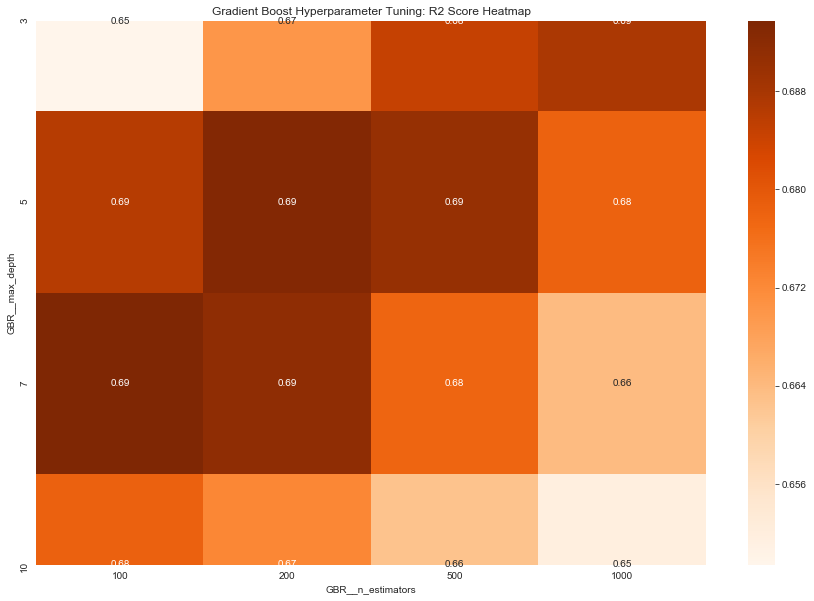

In [118]:
cv_df = pd.DataFrame(cv.cv_results_["params"])
cv_df["mean_train_score"] = cv.cv_results_["mean_test_score"]

cv_ind = cv_df.columns[0]
cv_col = cv_df.columns[1]
cv_val = cv_df.columns[2]

cv_df = cv_df.pivot(index=cv_ind, columns=cv_col, values=cv_val)

f, axes = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(cv_df, annot=True, cmap="Oranges")
ax.set(title="Gradient Boost Hyperparameter Tuning: R2 Score Heatmap")
plt.show()

__<font size = 5 color ='red' > Feature Importance </font>__

The Gradient Boost approach gave the highest accuracy. In order to make a model using all the features, we can further improve the model by taking feature importance into account. Below, we use Mutual Information (MI) as a scoring method to rank each feature.
`Note`:  Original dataset had only 24 features but because of one-hot encoding, the feature count expanded to 95.

In [120]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

kbest = SelectKBest(score_func=mutual_info_regression, k=5)
kbest.fit(X, y)

feature_names = X.columns
feature_scores = list(zip(feature_names, kbest.scores_))

feature_scores.sort(key=lambda x:x[1], reverse=True)

for item in feature_scores[:10]:
    print("Score of " ": ",
          (item[0], item[1]))

SelectKBest(k=5, score_func=<function mutual_info_regression at 0x1a34285840>)

Score of :  ('accommodates', 0.31804591809345917)
Score of :  ('Total no. of crimes', 0.18130981151484216)
Score of :  ('Theft', 0.17877465673321957)
Score of :  ('Burglary', 0.1747902611026646)
Score of :  ('Auto Theft', 0.17363241002012852)
Score of :  ('room_type_Private room', 0.16793352832524455)
Score of :  ('guests_included', 0.16641762585406772)
Score of :  ('Rape', 0.16455254209436987)
Score of :  ('Aggravated Assault', 0.15673135350873446)
Score of :  ('Robbery', 0.15143320960166706)


[Text(0, 0.5, 'Feature'),
 Text(0.5, 0, 'Mutual Information Score'),
 Text(0.5, 1.0, 'Top 10 Feature Importance')]

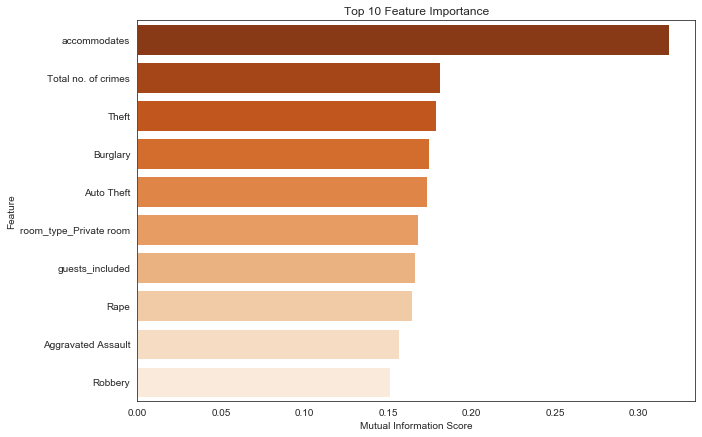

In [121]:
top_features = np.array(feature_scores[:10])

f, axes = plt.subplots(figsize=(10,7))
ax = sns.barplot(x=[float(i) for i in top_features[:,1]], \
                 y=top_features[:,0], \
                 palette = "Oranges_r")
ax.set(title="Top 10 Feature Importance", xlabel="Mutual Information Score", \
       ylabel="Feature")
plt.show()

**** Here are the R2 scores calculated using the best parameters for best estimator on the top N features. ****

In [122]:
kbestscores = []

for rank in [5, 10, 25, 50, 60, 70, 80, 90]:
    kbest = SelectKBest(score_func=mutual_info_regression, 
                        k=rank)
    kbest.fit(X, y)
    X_new = kbest.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

    gbr = GradientBoostingRegressor(random_state=42, 
                                    loss="huber", 
                                    n_estimators=500, 
                                    max_depth=3)
    gbr.fit(X_train, np.ravel(y_train))

    gbr_score = gbr.score(X_train, y_train)*100
    kbestscores.append((rank, gbr_score))

for item in kbestscores:
    print("Score with Only the Top Features: " 
          , (item[0], item[1]))

SelectKBest(k=5, score_func=<function mutual_info_regression at 0x1a34285840>)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

SelectKBest(k=10,
      score_func=<function mutual_info_regression at 0x1a34285840>)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

SelectKBest(k=25,
      score_func=<function mutual_info_regression at 0x1a34285840>)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

SelectKBest(k=50,
      score_func=<function mutual_info_regression at 0x1a34285840>)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

SelectKBest(k=60,
      score_func=<function mutual_info_regression at 0x1a34285840>)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

SelectKBest(k=70,
      score_func=<function mutual_info_regression at 0x1a34285840>)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

SelectKBest(k=80,
      score_func=<function mutual_info_regression at 0x1a34285840>)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

SelectKBest(k=90,
      score_func=<function mutual_info_regression at 0x1a34285840>)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

Score with Only the Top Features:  (5, 48.74247900957782)
Score with Only the Top Features:  (10, 54.367980519439044)
Score with Only the Top Features:  (25, 69.60019860423941)
Score with Only the Top Features:  (50, 73.25470277947579)
Score with Only the Top Features:  (60, 73.9269292635585)
Score with Only the Top Features:  (70, 73.77771981922103)
Score with Only the Top Features:  (80, 73.7379981794741)
Score with Only the Top Features:  (90, 73.66592108969611)


[Text(0, 0.5, 'R2 Score (%)'),
 Text(0.5, 0, '# of Top Features Used'),
 Text(0.5, 1.0, 'Training Set Scores Using the Top N Features')]

(40, 80)

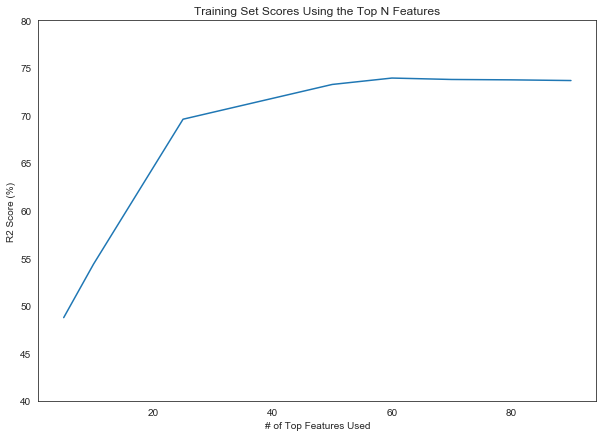

In [123]:
kbestscores = np.array(kbestscores)
rank = kbestscores[:,0]
gbr_score = kbestscores[:,1]

f, axes = plt.subplots(figsize=(10,7))
ax = sns.lineplot(rank, gbr_score)
ax.set(title="Training Set Scores Using the Top N Features", \
       xlabel="# of Top Features Used", \
       ylabel="R2 Score (%)")
#ax.set_ylim([0, 100])
ax.set_ylim([40, 80])
plt.show()

__<font size = 5 color = 'red' > FINAL FINAL RESULTS </font>__

After feature selecton, feature importance and knowing the best estimator, it is time to check the model on the test set. 

In [124]:
best_feat_count = max(kbestscores, key=lambda x:x[1])
best_feat_count = int(best_feat_count[0])

kbest = SelectKBest(score_func=mutual_info_regression, \
                    k=best_feat_count)
kbest.fit(X, y)
X_new = kbest.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(random_state=42, 
                                loss="huber", 
                                n_estimators=500, 
                                max_depth=3)
gbr.fit(X_train, np.ravel(y_train))

train_score = gbr.score(X_train, y_train)*100
test_score = gbr.score(X_test, y_test)*100

print("Training set score: " , train_score)
print("Test set score: " , test_score)

SelectKBest(k=60,
      score_func=<function mutual_info_regression at 0x1a34285840>)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

Training set score:  73.54822659664775
Test set score:  68.83596982869392


__<font size = 5 color = 'purple' > Conclusion and Recommendation </font>__

We ended up with about 2/3 of the original columns to make a simple and less complex model.  Reducuing futher, might results in the overfitting.

Once can also, modify this 2019 data, by comparing and different model. especially taking care of the outliers and selecting other features. 

Once can also try making the multiple regression models

<font size =3 color = 'blue' > In addition to the above analysis of the data sets, here I have used zipcodes to make the map of the Austin, Tx and overlap with the set of information we have from the AirBnb listing data and the crimes daats. I have made only few of the plots, but on can further explore this to plot different variables for better visualization. </font>

__<font size = 4 color = 'green' >  DataSet ZipCodes (Boundaries) </font>__

In third dataset I wanted to explore the date obtain from Boundaries which specifies the location and zipcodes for the Austin, TX. 

Here I tried to plot the map in the background and tried to highlight few of the features in the data set like, top 50 Most Reviewd listings, crimes map, arbnb listing in year 2019. 

Figures (maps) genrated are self explanatory. 

This can be further explored for presentation and for visluization . 

In [125]:
import geopandas as gpd
austin_map = gpd.read_file("/Users/nitinmahajan/Desktop/Austin_2019_AirBNB/Boundaries_ Austin_Zip Code Tabulation Areas, 2017.geojson")


In [126]:
austin_map.head()

,awater10,affgeoid10,zcta5ce10,aland10,geoid10,geometry
0,1463994,8600000US78612,78612,243022885,78612,"MULTIPOLYGON (((-97.52751 30.09283, -97.52721 ..."
1,1296973,8600000US78653,78653,271051043,78653,"MULTIPOLYGON (((-97.63882 30.35289, -97.63077 ..."
2,0,8600000US78757,78757,12732626,78757,"MULTIPOLYGON (((-97.75501 30.33623, -97.74342 ..."
3,47149,8600000US78721,78721,9588238,78721,"MULTIPOLYGON (((-97.70142 30.28139, -97.70171 ..."
4,0,8600000US78745,78745,34597868,78745,"MULTIPOLYGON (((-97.84494 30.20041, -97.83965 ..."


In [127]:
austin_map.dtypes

awater10        object
affgeoid10      object
zcta5ce10       object
aland10         object
geoid10         object
geometry      geometry
dtype: object

In [128]:
# A new coulmm is made `ZipCode` which is a copy of `geoid10`
austin_map["zipcode"] = austin_map["geoid10"].astype(int) ####geoids

print(type(austin_map))
display(austin_map.head())

<class 'geopandas.geodataframe.GeoDataFrame'>


,awater10,affgeoid10,zcta5ce10,aland10,geoid10,geometry,zipcode
0,1463994,8600000US78612,78612,243022885,78612,"MULTIPOLYGON (((-97.52751 30.09283, -97.52721 ...",78612
1,1296973,8600000US78653,78653,271051043,78653,"MULTIPOLYGON (((-97.63882 30.35289, -97.63077 ...",78653
2,0,8600000US78757,78757,12732626,78757,"MULTIPOLYGON (((-97.75501 30.33623, -97.74342 ...",78757
3,47149,8600000US78721,78721,9588238,78721,"MULTIPOLYGON (((-97.70142 30.28139, -97.70171 ...",78721
4,0,8600000US78745,78745,34597868,78745,"MULTIPOLYGON (((-97.84494 30.20041, -97.83965 ...",78745


In [129]:
austin_map["zipcode"].dtype

dtype('int64')

In [130]:
austin_map.dtypes

awater10        object
affgeoid10      object
zcta5ce10       object
aland10         object
geoid10         object
geometry      geometry
zipcode          int64
dtype: object

zipcode
78653    Annotation(-97.5236, 30.3394, '78653')
78757    Annotation(-97.7325, 30.3516, '78757')
78721    Annotation(-97.6837, 30.2701, '78721')
78745    Annotation(-97.7974, 30.2068, '78745')
78751    Annotation(-97.7227, 30.3108, '78751')
78702    Annotation(-97.7143, 30.2633, '78702')
78741     Annotation(-97.714, 30.2305, '78741')
78704    Annotation(-97.7654, 30.2432, '78704')
78746    Annotation(-97.8105, 30.2973, '78746')
78722      Annotation(-97.7146, 30.29, '78722')
78756    Annotation(-97.7402, 30.3223, '78756')
78742    Annotation(-97.6583, 30.2441, '78742')
78738    Annotation(-97.9583, 30.3194, '78738')
78732    Annotation(-97.8931, 30.3791, '78732')
78613     Annotation(-97.8246, 30.504, '78613')
78731    Annotation(-97.7685, 30.3474, '78731')
78712     Annotation(-97.7348, 30.285, '78712')
78723    Annotation(-97.6857, 30.3043, '78723')
78733    Annotation(-97.8761, 30.3232, '78733')
78758     Annotation(-97.7068, 30.388, '78758')
78726    Annotation(-97.8421, 30

(-98.05629044999999, -97.39306855, 30.041804900000002, 30.616865100000005)

Text(0.5, 1, 'Airbnb Listings in Austin, TX \n(Year 2019)')

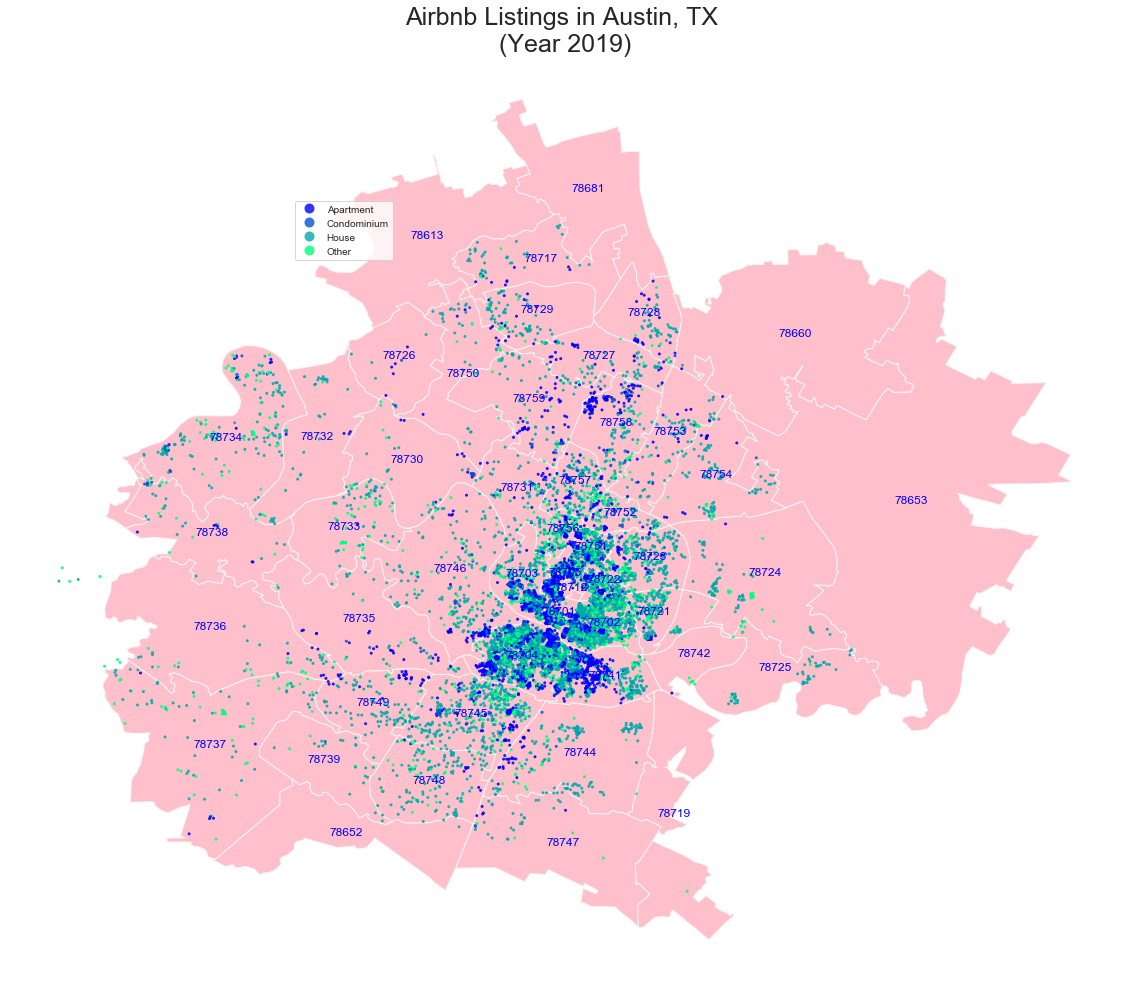

In [131]:
### INstall --conda install descartes--

# Error : ImportError: The descartes package is required for plotting polygons in geopandas.


listings_df = pd.merge(listings[["id", "latitude", "longitude"]], 
                       df, how="right", on="id")
listings_df = listings_df[["zipcode", "id", "latitude", "longitude", 
                           "property_type (simple)"]]
listings_df["Point"] = listings_df.apply(lambda row: 
                                         Point(row["longitude"], 
                                               row["latitude"]), axis=1)
listings_df = gpd.GeoDataFrame(listings_df, geometry="Point")

geo_df = listings_df.groupby("zipcode").count()
geo_df = pd.merge(austin_map, geo_df, how="right", on="zipcode")
geo_df = geo_df.set_index("zipcode")

fig, ax = plt.subplots(figsize=(20,20))

base = geo_df.plot(color="pink", 
                   edgecolor="whitesmoke", ax=ax)
geo_df.apply(lambda x: ax.annotate(s=x.name, 
                                   xy=x.geometry.centroid.coords[0], 
                                   ha="center", fontweight="light", 
                                   fontsize=12, color="blue"), axis=1)
base.axis("off")

listings_df.plot(ax=base, cmap="winter", marker="o", markersize=4, 
                 alpha=.8, column="property_type (simple)", 
                 categorical=True, legend=True)

legend = ax.get_legend()
legend.set_bbox_to_anchor((0.25, 0.75, 0.10, 0.10))

plt.title("Airbnb Listings in Austin, TX \n(Year 2019)", 
          fontdict={"fontsize":25})

plt.show()

In [ ]:
price_df = df.pivot_table(index="zipcode", values="price", aggfunc="mean")
price_df = pd.merge(austin_map, price_df, how="right", on="zipcode")
price_df = price_df.set_index("zipcode")

fig, ax = plt.subplots(figsize=(20,20))

base = price_df.plot(column="price", cmap="cool", 
                     edgecolor="whitesmoke", ax=ax)
price_df.apply(lambda x: ax.annotate(s=x.name, 
                                     xy=x.geometry.centroid.coords[0], 
                                     ha="center", fontweight="light", 
                                     fontsize=14, color="black"), axis=1)
base.axis("off")

min_price = price_df["price"].min()
max_price = price_df["price"].max()
gradient = plt.cm.ScalarMappable(cmap="cool", 
                                 norm=plt.Normalize(vmin=min_price, 
                                                    vmax=max_price))
gradient._A = []
cbar = fig.colorbar(gradient, fraction=0.04, pad=.01)

listings_df.plot(ax=base, color="black", marker="*", markersize=4, 
                 alpha=.5, label="Listings")

cbar.ax.set_yticklabels(["$" + i.get_text() for i in cbar.ax.get_yticklabels()])

legend = plt.legend(facecolor="w", edgecolor="darkgray", fontsize=12)
legend.set_bbox_to_anchor((0.25, 0.75, 0.10, 0.10))

plt.title("Average Nightly Rate of AnB Listings in Austin, TX by Zip Code YEAR 2019", 
          fontdict={"fontsize":25})

plt.show()

zipcode
78653    Annotation(-97.5236, 30.3394, '78653')
78757    Annotation(-97.7325, 30.3516, '78757')
78721    Annotation(-97.6837, 30.2701, '78721')
78745    Annotation(-97.7974, 30.2068, '78745')
78751    Annotation(-97.7227, 30.3108, '78751')
78702    Annotation(-97.7143, 30.2633, '78702')
78741     Annotation(-97.714, 30.2305, '78741')
78704    Annotation(-97.7654, 30.2432, '78704')
78746    Annotation(-97.8105, 30.2973, '78746')
78722      Annotation(-97.7146, 30.29, '78722')
78756    Annotation(-97.7402, 30.3223, '78756')
78742    Annotation(-97.6583, 30.2441, '78742')
78738    Annotation(-97.9583, 30.3194, '78738')
78732    Annotation(-97.8931, 30.3791, '78732')
78613     Annotation(-97.8246, 30.504, '78613')
78731    Annotation(-97.7685, 30.3474, '78731')
78712     Annotation(-97.7348, 30.285, '78712')
78723    Annotation(-97.6857, 30.3043, '78723')
78733    Annotation(-97.8761, 30.3232, '78733')
78758     Annotation(-97.7068, 30.388, '78758')
78726    Annotation(-97.8421, 30

(-98.05629044999999, -97.39306855, 30.041804900000002, 30.616865100000005)

[Text(1, 100.0, '$100'),
 Text(1, 200.0, '$200'),
 Text(1, 300.0, '$300'),
 Text(1, 400.0, '$400'),
 Text(1, 500.0, '$500')]

Text(0.5, 1, 'Top 50 AnB Listings in Austin, TX\n(Year 2019) and price gradient')

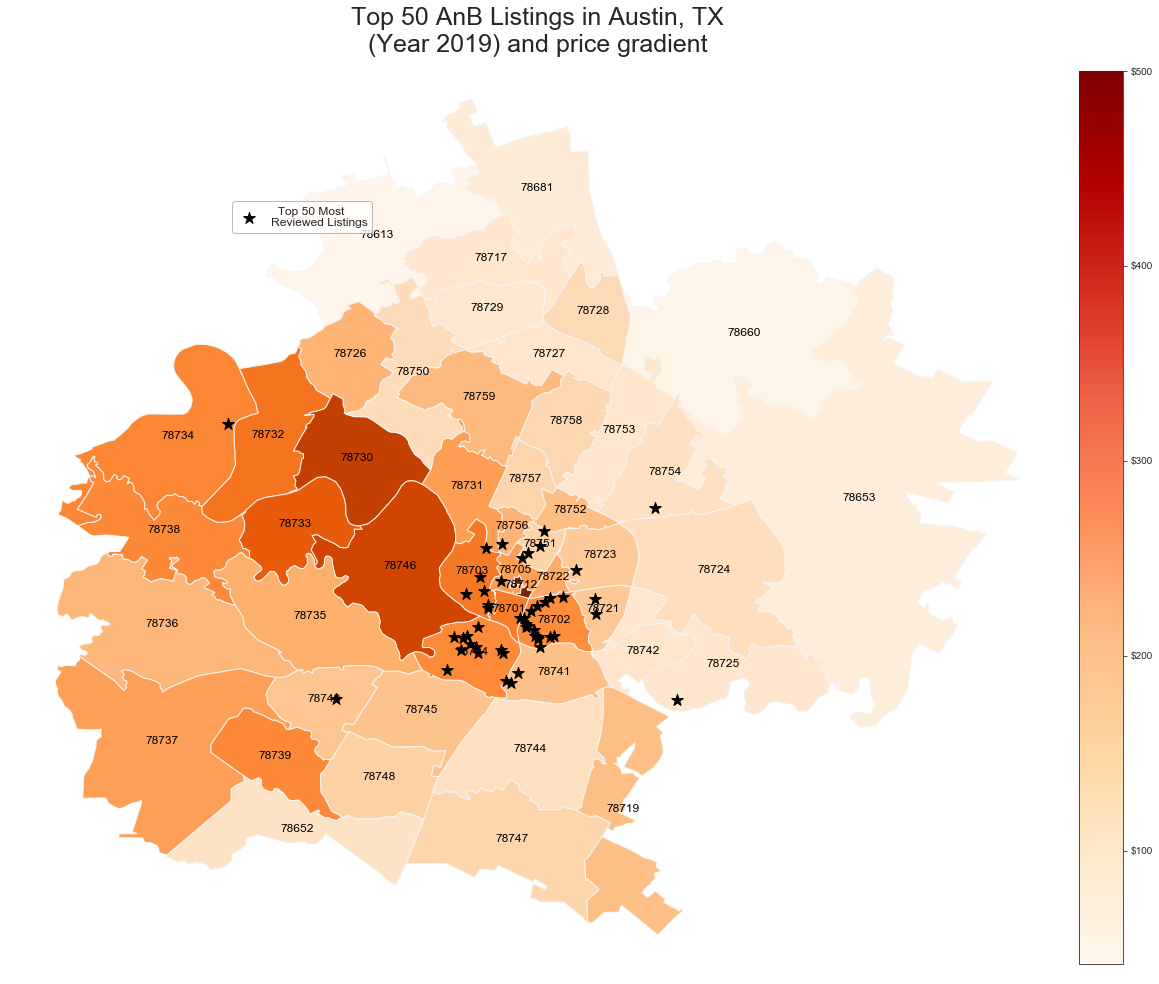

In [132]:
reviews_df = pd.merge(listings[["id", "latitude", "longitude"]], \
                      df, how="right", on="id")
reviews_df = reviews_df[["zipcode", "id", "latitude", "longitude", \
                         "number_of_reviews"]]
reviews_df["Point"] = reviews_df.apply(lambda row: \
                                       Point(row["longitude"], \
                                             row["latitude"]), axis=1)
reviews_df = gpd.GeoDataFrame(reviews_df, geometry="Point")
reviews_df = reviews_df.sort_values("number_of_reviews", ascending=False)
reviews_df = reviews_df.iloc[0:50]

price_df = df.pivot_table(index="zipcode", values="price", aggfunc="mean")
price_df = pd.merge(austin_map, price_df, how="right", on="zipcode")
price_df = price_df.set_index("zipcode")

fig, ax = plt.subplots(figsize=(20,20))

base = price_df.plot(column="price", cmap="Oranges", 
                   edgecolor="whitesmoke", ax=ax)
price_df.apply(lambda x: ax.annotate(s=x.name, \
                                     xy=x.geometry.centroid.coords[0], \
                                     ha="center", fontweight="light", \
                                     fontsize=12, color="black"), axis=1)
base.axis("off")

min_price = price_df["price"].min()
max_price = price_df["price"].max()
gradient = plt.cm.ScalarMappable(cmap="OrRd", \
                                 norm=plt.Normalize(vmin=min_price, \
                                                    vmax=max_price))
gradient._A = []
cbar = fig.colorbar(gradient, fraction=0.04, pad=.01)

reviews_df.plot(ax=base, color="black", marker="*", markersize=150, \
                alpha=1, label="  Top 50 Most\nReviewed Listings")

cbar.ax.set_yticklabels(["$" + i.get_text() for i in cbar.ax.get_yticklabels()])

legend = plt.legend(facecolor="w", edgecolor="darkgray", fontsize=12)
legend.set_bbox_to_anchor((0.25, 0.75, 0.10, 0.10))

plt.title("Top 50 AnB Listings in Austin, TX\n(Year 2019) and price gradient", \
          fontdict={"fontsize":25})

plt.show()